In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr
import os

In [2]:
G = 6.67430e-8
Msun = 1.989e33
Lsun = 3.828e33
Rsun = 6.96e10

secinyear = 3.154e7
secinday = 86400

In [3]:
def index_of_radius(radius,profile):
    return np.argmin(np.abs(10**profile.logR-radius))

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def Pterm(Menc,T,rho,kappa,grad_rad,grad_ad):
    return (Menc*T**4/(rho*kappa))*(grad_rad-grad_ad)

# 15 Msun stock model from Evan's code

In [4]:
profMS = mr.MesaData('/home/swu/compressible_stars_CP/compstar/stock_models/zams_15Msol/LOGS/profile47.data')

In [5]:
from astropy import constants
from astropy import units as u
from scipy.interpolate import interp1d
# profMS.gamma1, profMS.entropy, profMS,rho, profMS.luminosity, profMS.conv_L_div_L, profMS.gradT, constants.R.cgs, profMS.mu*u.g/u.mol, constants.G.cgs*profMs.mass/profMS.radius**2

In [6]:
gamma = profMS.gamma1
# s = (profMS.entropy*constants.N_A*constants.k_B.cgs).value


R_gas = constants.R.cgs/(profMS.mu[-1]*u.g/u.mol) #want innermost value of mu eventually
cp = profMS.cp #R_gas.value*profMS.gamma1/(profMS.gamma1-1)


rho = profMS.rho
P = profMS.pressure
T = profMS.temperature
radius_cgs = profMS.radius*Rsun
grav = -constants.G.cgs*profMS.mass*Msun/radius_cgs**2
N2 = profMS.brunt_N2
grad_s_over_cp = N2/(-grav.value)
grad_s = cp*grad_s_over_cp

L = profMS.luminosity*Lsun
Lconv = profMS.lum_conv_div_L*profMS.luminosity*Lsun
nablaT = profMS.gradT

dlogPdr = -rho*(-grav.value)/P
dlogTdr = nablaT*dlogPdr
gradT = dlogTdr*T

chi_rad = -(L-Lconv)/gradT/(4*np.pi*radius_cgs**2)/rho/cp

pomega = R_gas.value*T

hse = (gamma*pomega)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega

# hse = (gamma*pomega/profMS.pgas_div_ptotal)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega

In [38]:
conv_core_condition = (Lconv>1)*(profMS.mass < 0.9*profMS.mass[0])
# print(profMS.mass[conv_core_condition][0])
core_index = np.argmin(np.abs(profMS.mass-profMS.mass[conv_core_condition][0]))
# print(profMS.mass[core_index])
core_cz_radius = radius_cgs[core_index]
# print(core_cz_radius/Rsun)
brunt_N2_max = np.amax(profMS.brunt_N2[profMS.mass < profMS.mass[0]*0.95])
brunt_N2_maxind = np.argmin(np.abs(profMS.brunt_N2-brunt_N2_max))

f_brunt = np.sqrt(brunt_N2_max)/(2*np.pi)


L_CZ    = core_cz_radius
m_core  = rho[-1] * L_CZ**3
T_core  = T[-1]
H0      = (rho*profMS.eps_nuc)[-1]
print(m_core/Msun,f'{T_core:1.2E}',f'{H0:1.2E}')
tau_heat  = ((H0*L_CZ/m_core)**(-1/3)) #heating timescale
L_nd    = L_CZ
m_nd    = rho[radius_cgs==L_nd][-1] * L_nd**3 #mass at core cz boundary
T_nd    = T[radius_cgs==L_nd][-1] #temp at core cz boundary
# tau_nd  = (1/f_brunt) #timescale of max N^2
tau_nd = 9.19e+03 #s #just make it match for now to check something
rho_nd  = m_nd/L_nd**3
u_nd    = L_nd/tau_nd
s_nd    = L_nd**2 / tau_nd**2 / T_nd
H_nd    = (m_nd / L_nd) * tau_nd**-3
s_motions    = L_nd**2 / tau_heat**2 / T[-1]
lum_nd  = L_nd**2 * m_nd / (tau_nd**2) / tau_nd
nondim_R_gas = (R_gas / s_nd).cgs.value
nondim_gamma1 = (gamma[-1])
nondim_cp = nondim_R_gas * nondim_gamma1 / (nondim_gamma1 - 1)
u_heat_nd = (L_nd/tau_heat) / u_nd
Ma2_r0 = ((u_nd*(tau_nd/tau_heat))**2 / ((gamma[-1]-1)*cp[-1]*T[-1]))
print('Nondimensionalization: L_nd = {:.2e}, T_nd = {:.2e}, m_nd = {:.2e}, tau_nd = {:.2e}'.format(L_nd, T_nd, m_nd, tau_nd))
print('Thermo: Cp/s_nd: {:.2e}, R_gas/s_nd: {:.2e}, gamma1: {:.4f}'.format(nondim_cp, nondim_R_gas, nondim_gamma1))
print(r'm_nd/M$_\odot$: {:.3f}'.format((m_nd*u.g/constants.M_sun).cgs))
print('estimated mach number: {:.3e} / t_heat: {:.3e}'.format(np.sqrt(Ma2_r0), tau_heat))

#for the star_builder.py f'n, the entropy background comes from HSE_solve. only load in grad_s0 since that's the only thing that appears in eq'ns
# s = cp * ((1/gamma)*(np.log(pomega) + np.log(rho)) - np.log(rho))
# s0 = s/s_nd # nondimensionalize?
pom0 = pomega/s_nd/T_nd
ln_rho0 = np.log(rho/rho_nd)
s0 = nondim_cp*((1/nondim_gamma1)*(np.log(pom0)+ln_rho0) - ln_rho0)
eos = s0/nondim_cp - ( (1/nondim_gamma1) * (np.log(pom0) - np.log(nondim_R_gas)) - ((nondim_gamma1-1)/nondim_gamma1) * ln_rho0 )

r_nd = (radius_cgs/L_nd)


2.166885638270461 3.63E+07 5.17E+05
Nondimensionalization: L_nd = 8.21e+10, T_nd = 2.35e+07, m_nd = 1.89e+33, tau_nd = 9.19e+03
Thermo: Cp/s_nd: 1.14e+02, R_gas/s_nd: 4.10e+01, gamma1: 1.5603
m_nd/M$_\odot$: 0.951
estimated mach number: 1.491e-03 / t_heat: 4.665e+05


In [39]:
from collections import OrderedDict
interp_kwargs = {'fill_value' : 'extrapolate', 'bounds_error' : False}
interpolations = OrderedDict()
interpolations['ln_rho0'] = interp1d(r_nd, np.log(rho/rho_nd), **interp_kwargs)
interpolations['ln_T0'] = interp1d(r_nd, np.log(T/T_nd), **interp_kwargs)
interpolations['T0'] = interp1d(r_nd, T/T_nd, **interp_kwargs)

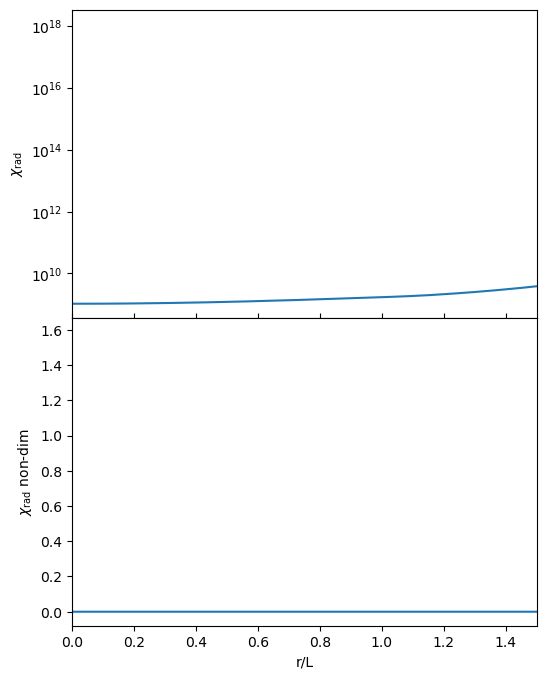

In [12]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,chi_rad)
ax[1].plot(radius_cgs/L_nd,chi_rad * (tau_nd / L_nd**2))

ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\chi_{\rm rad}$')
ax[1].set_ylabel(r'$\chi_{\rm rad}$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)

for i in range(2):
    ax[i].set_xlim(0,1.5)
plt.subplots_adjust(hspace=0)

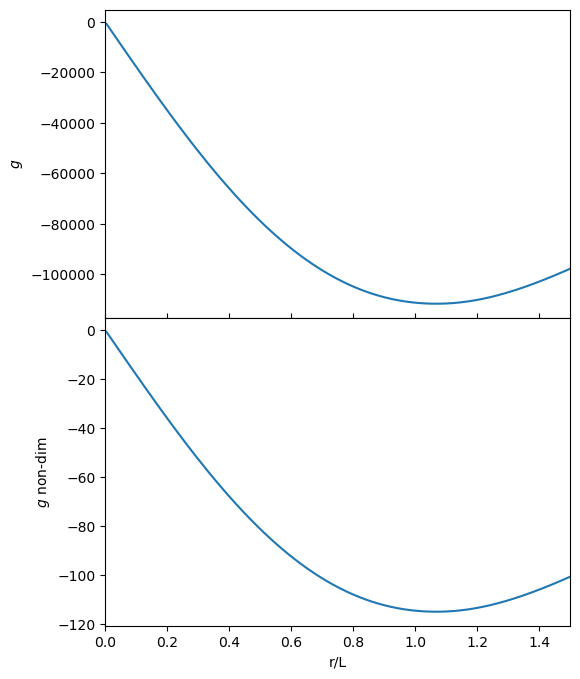

In [13]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,grav.value)
ax[1].plot(radius_cgs/L_nd,grav.value * (tau_nd**2/L_nd))

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$g$')
ax[1].set_ylabel(r'$g$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
for i in range(2):
    ax[i].set_xlim(0,1.5)
plt.subplots_adjust(hspace=0)

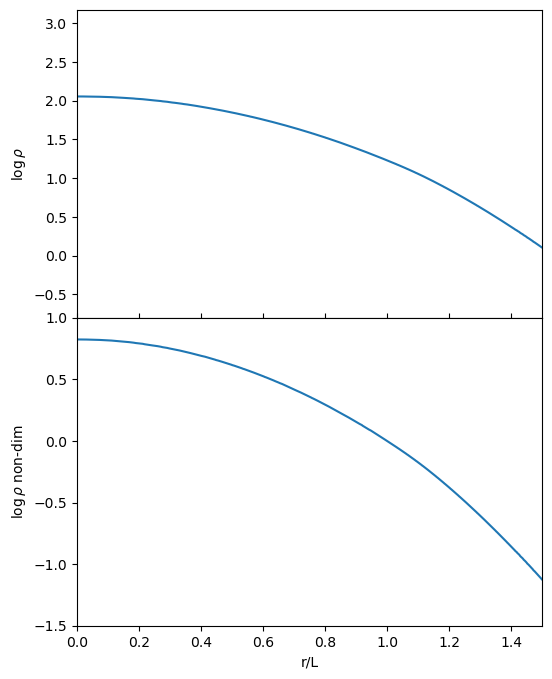

In [14]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,np.log(rho))
ax[1].plot(radius_cgs/L_nd,np.log(rho/rho_nd))

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\log\rho$')
ax[1].set_ylabel(r'$\log\rho$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
ax[1].set_ylim(-1.5,1)
ax[0].set_ylim(-0.8,)
for i in range(2):
    ax[i].set_xlim(0,1.5)
    
plt.subplots_adjust(hspace=0)

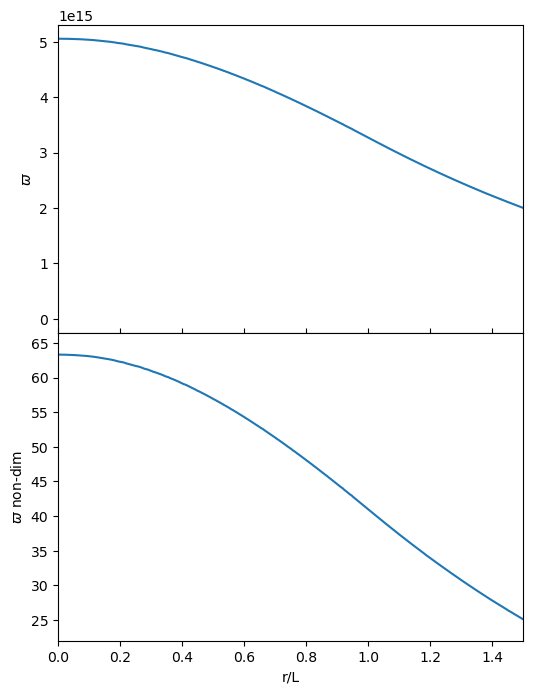

In [15]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,pomega)
ax[1].plot(radius_cgs/L_nd,pom0)

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\varpi$')
ax[1].set_ylabel(r'$\varpi$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
# ax[1].set_ylim(-1.5,1)
ax[1].set_ylim(22,)
for i in range(2):
    ax[i].set_xlim(0,1.5)
    
plt.subplots_adjust(hspace=0)

opacity

In [6]:
profMS.bulk_names

('zone',
 'mass',
 'q',
 'logdq',
 'log_q',
 'temperature',
 'rho',
 'logRho',
 'entropy',
 'pressure',
 'opacity',
 'radius',
 'velocity',
 'luminosity',
 'eps_nuc',
 'net_nuclear_energy',
 'eps_grav',
 'ye',
 'mixing_type',
 'mlt_mixing_length',
 'mlt_mixing_type',
 'pressure_scale_height',
 'lum_conv_div_lum_rad',
 'lum_conv_div_L',
 'csound',
 'mu',
 'tau',
 'logtau',
 'grada',
 'cv',
 'cp',
 'gamma1',
 'chiRho',
 'chiT',
 'log_opacity',
 'log_D_mix',
 'log_conv_vel',
 'conv_vel_div_csound',
 'log_mlt_D_mix',
 'gradT',
 'gradr',
 'h1',
 'he3',
 'he4',
 'c12',
 'n14',
 'o16',
 'ne20',
 'mg24',
 'pp',
 'cno',
 'tri_alfa',
 'c_alpha',
 'n_alpha',
 'o_alpha',
 'ne_alpha',
 'na_alpha',
 'mg_alpha',
 'si_alpha',
 's_alpha',
 'ar_alpha',
 'ca_alpha',
 'ti_alpha',
 'cr_alpha',
 'fe_co_ni',
 'c12_c12',
 'c12_o16',
 'o16_o16',
 'pnhe4',
 'photo',
 'ni56_co56',
 'co56_fe56',
 'other',
 'brunt_N2',
 'brunt_N2_structure_term',
 'brunt_N2_composition_term',
 'brunt_N',
 'log_F_div_rhocs3',
 'log

16.46015137403402


Text(0, 0.5, 'opacity')

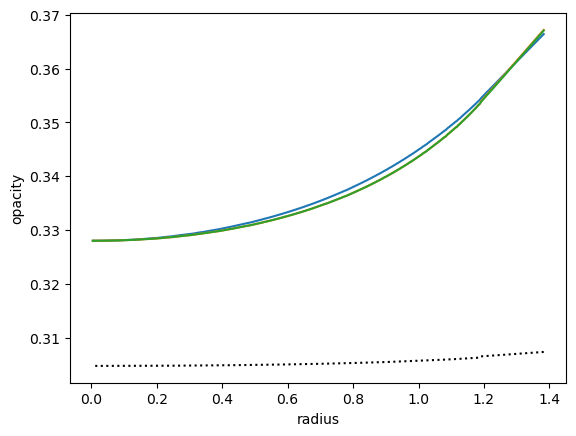

In [17]:
r_out = 6.88e+10*1.4/Rsun

kappa_ff = lambda rho,T,Z,X: 3.68e22*(1-Z)*(1+X)*rho*T**(-7/2)
kappa_bf = lambda rho,T,Z,X: 4.34e25*Z*(1+X)*rho*T**(-7/2)
# gff=16.5
# gbf=1e-4
z_frac = 1-profMS.h1-profMS.he4-profMS.he3
x_frac = profMS.h1
new_opacity = profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,z_frac,x_frac)[profMS.radius<r_out])
gff = (profMS.opacity[-1] - new_opacity[-1])/profMS.ye[-1]/kappa_ff(profMS.rho,profMS.temperature,z_frac,x_frac)[-1] + 1

z_frac_const = (1-profMS.h1-profMS.he4-profMS.he3)[-1]
x_frac_const= profMS.h1[-1] #const should work
new_opacity_const = profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,z_frac_const,x_frac_const)[profMS.radius<r_out])
gff_const = (profMS.opacity[-1] - new_opacity_const[-1])/profMS.ye[-1]/kappa_ff(profMS.rho,profMS.temperature,z_frac_const,x_frac_const)[-1] + 1
print(gff)
plt.plot(profMS.radius[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],
        profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,z_frac_const,x_frac_const)[profMS.radius<r_out]) )
plt.plot(profMS.radius[profMS.radius<r_out],new_opacity,ls=':',color='black')
plt.plot(profMS.radius[profMS.radius<r_out],
        profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac_const)+gff_const*kappa_ff(profMS.rho,profMS.temperature,z_frac_const,x_frac_const)[profMS.radius<r_out]) )
# plt.plot(profMS.radius[profMS.radius<r_out],
#         profMS.ye[profMS.radius<r_out]*(0.2*(1+profMS.x[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out]) 
#         + (1-profMS.ye[profMS.radius<r_out])*gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.yscale('log') 
# plt.xscale('log')
plt.xlabel('radius')
plt.ylabel('opacity')

In [34]:
def adjust_opacity(mesa_file):
        """
        Change the opacity to one that follows a Kramer's opacity + constant (electron scattering)
        """
        p = mr.MesaData(mesa_file)
        opacity = p.opacity[::-1] #* (u.cm**2 / u.g)
        h1 = p.h1[::-1]
        he3 = p.he3[::-1]
        he4 = p.he4[::-1]
        ye = p.ye[::-1]
        x_frac = h1
        z_frac = 1-(h1 + he3 + he4)
        rho = 10**p.logRho[::-1] #* u.g / u.cm**3
        T = p.temperature[::-1] #* u.K

        kappa_ff = lambda rho,T,Z,X: 3.68e22*(1-Z)*(1+X)*rho*T**(-7/2)
        # kappa_bf = lambda rho,T,Z,X: 4.34e25*Z*(1+X)*rho*T**(-7/2)

        z_frac = (1-h1-he4-he3)[0]
        x_frac = h1[0]
        new_opacity = ye[0]*(0.2*(1+x_frac)+kappa_ff(rho,T,z_frac,x_frac))
        gff = (opacity[0] - new_opacity[0])/ye[0]/kappa_ff(rho,T,z_frac,x_frac)[0] + 1
        print(gff)
        opacity_adj = ye[0]*(0.2*(1+x_frac)+gff*kappa_ff(rho,T,z_frac,x_frac)) 
        return opacity_adj * (u.cm**2 / u.g), gff, z_frac,x_frac,ye[0]
def opacity_func(rho,T,gff,z_frac,x_frac,ye):
        kappa_ff = lambda rho,T,Z,X: 3.68e22*(1-Z)*(1+X)*rho*T**(-7/2)
        return ye*(0.2*(1+x_frac)+gff*kappa_ff(rho,T,z_frac,x_frac)) * (u.cm**2 / u.g)

16.46015137403402
16.460151374034016


Text(0, 0.5, 'opacity')

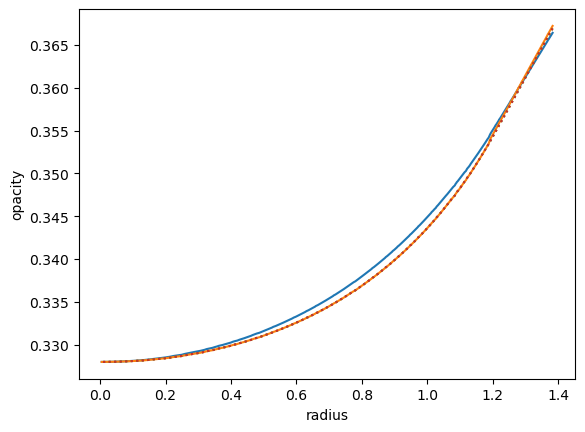

In [35]:

r_out = 6.88e+10*1.4/Rsun

kappa_ff = lambda rho,T,Z,X: 3.68e22*(1-Z)*(1+X)*rho*T**(-7/2)
kappa_bf = lambda rho,T,Z,X: 4.34e25*Z*(1+X)*rho*T**(-7/2)
# gff=16.5
# gbf=1e-4
z_frac = 1-profMS.h1-profMS.he4-profMS.he3
x_frac = profMS.h1
new_opacity = profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,z_frac,x_frac)[profMS.radius<r_out])
gff = (profMS.opacity[-1] - new_opacity[-1])/profMS.ye[-1]/kappa_ff(profMS.rho,profMS.temperature,z_frac,x_frac)[-1] + 1
print(gff)
plt.plot(profMS.radius[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],
        profMS.ye[profMS.radius<r_out]*(0.2*(1+x_frac[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,z_frac,x_frac)[profMS.radius<r_out]) )
adjusted_opacity, gff_out, z_frac_out,x_frac_out, ye_out = adjust_opacity(profMS.file_name)
plt.plot(profMS.radius[profMS.radius<r_out], adjusted_opacity[::-1][profMS.radius<r_out].cgs,ls=':')

plt.plot(profMS.radius[profMS.radius<r_out], 
         opacity_func(profMS.rho,profMS.temperature,gff_out,z_frac_out,x_frac_out,ye_out)[profMS.radius<r_out].cgs,ls=':')
# plt.plot(profMS.radius[profMS.radius<r_out],
#         profMS.ye[profMS.radius<r_out]*(0.2*(1+profMS.x[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out]) 
#         + (1-profMS.ye[profMS.radius<r_out])*gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('radius')
plt.ylabel('opacity')

test whether converting from dimensional/nondimensional opacity/chi_rad is consistent

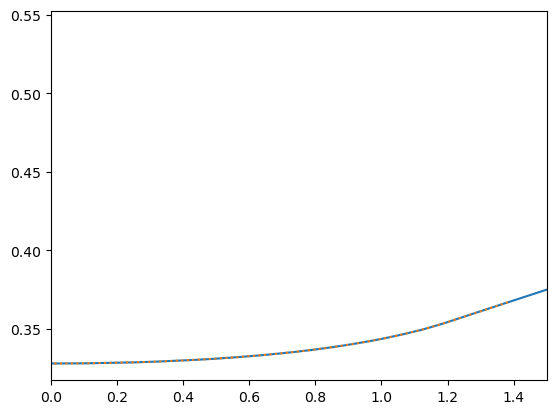

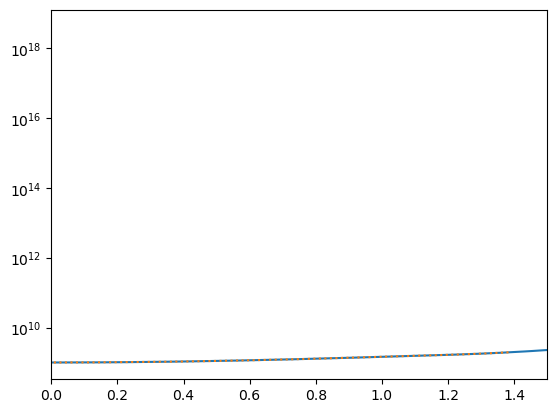

In [55]:
opacity_func_in = lambda rho, T: opacity_func(rho*rho_nd,T*T_nd,gff=gff_out,z_frac=z_frac_out,x_frac=x_frac_out,ye=ye_out)
#assuming rho, T are nondimensionalized inputs, but opacity_func returns a dimensionalized opacity 
rad_diff_func_in = lambda rho,T: (16 * constants.sigma_sb.cgs * (T*T_nd)**3 / (3 * (rho*rho_nd)**2 * cp * opacity_func_in(rho,T))) * (tau_nd / L_nd**2)
#assuming rho, T are nondimensionalized inputs, but will return dimensionalized rad_diff so must non-dimensionalize
opacity_adjusted =  opacity_func(profMS.rho,profMS.temperature,gff_out,z_frac_out,x_frac_out,ye_out)
rad_diff        = (16 * constants.sigma_sb.cgs * T**3 / (3 * rho**2 * cp * opacity_adjusted)).cgs
plt.figure()
plt.plot(r_nd*L_nd/Rsun,opacity_func_in(np.exp(interpolations['ln_rho0'](r_nd)),interpolations['T0'](r_nd)).cgs)
plt.plot(profMS.radius[profMS.radius<r_out], opacity_adjusted[profMS.radius<r_out].cgs
        ,ls=':')
plt.xlim(0,1.5)
# plt.ylim(0.32,0.37)

plt.figure()
plt.plot(r_nd*L_nd/Rsun,rad_diff_func_in(np.exp(interpolations['ln_rho0'](r_nd)),interpolations['T0'](r_nd)).cgs/((tau_nd)/L_nd**2))
plt.plot(profMS.radius[profMS.radius<r_out], rad_diff[profMS.radius<r_out].cgs,ls=':')
plt.xlim(0,1.5)
plt.yscale('log')
# plt.ylim(0.32,0.37)

## other plots

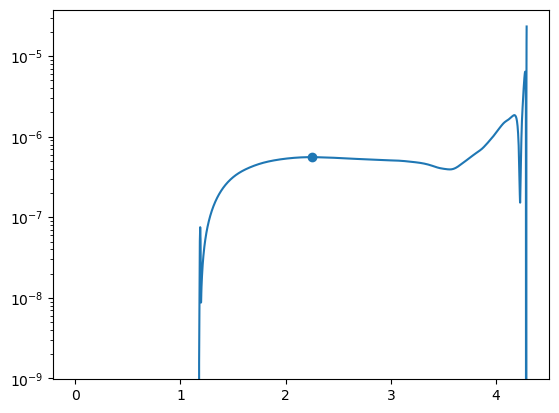

In [139]:
plt.plot(profMS.radius,profMS.brunt_N2)
plt.scatter(profMS.radius[brunt_N2_maxind],profMS.brunt_N2[brunt_N2_maxind])
plt.yscale('log')

(1e-09, np.float64(66217701.05825732))

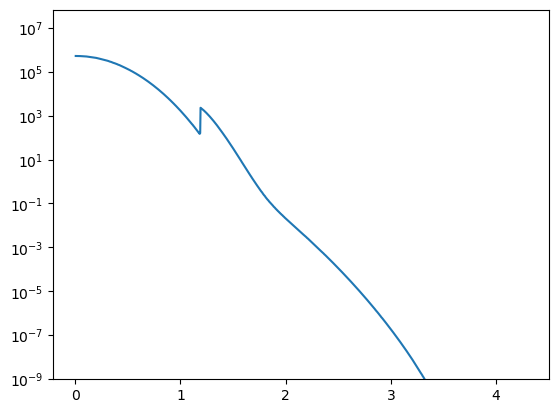

In [81]:
plt.plot(profMS.radius,rho*profMS.eps_nuc)
plt.yscale('log')
plt.ylim(1e-9,)

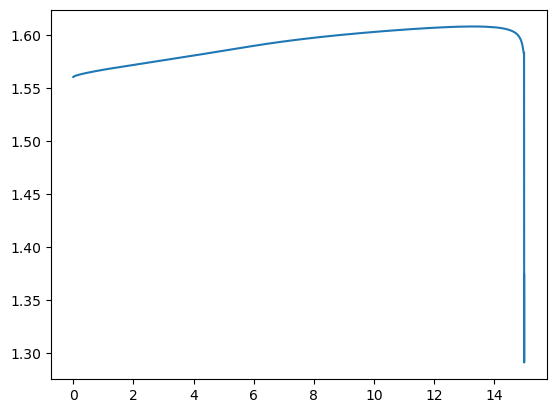

In [84]:
plt.plot(profMS.mass,gamma)

2.166885638270461 3.63E+07 5.17E+05
Nondimensionalization: L_nd = 8.21e+10, T_nd = 2.35e+07, m_nd = 1.89e+33, tau_nd = 9.19e+03
Thermo: Cp/s_nd: 1.14e+02, R_gas/s_nd: 4.10e+01, gamma1: 1.5603
m_nd/M$_\odot$: 0.951
estimated mach number: 1.491e-03 / t_heat: 4.665e+05


[2.38002675 2.38002675 2.38002675 ... 2.38002675 2.38002675 2.38002675]


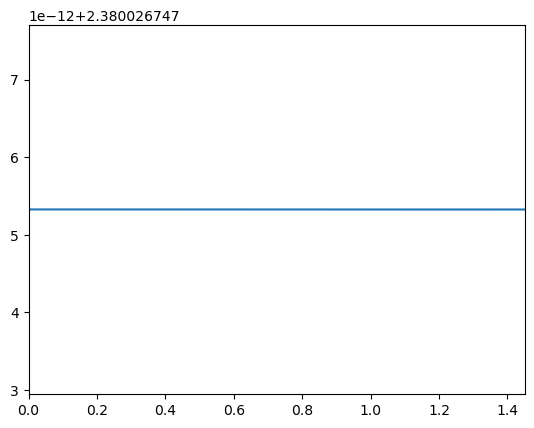

In [137]:
plt.plot(radius_cgs/L_nd,eos)
plt.xlim(0,1.45)
# plt.ylim(268,285)
print(eos)

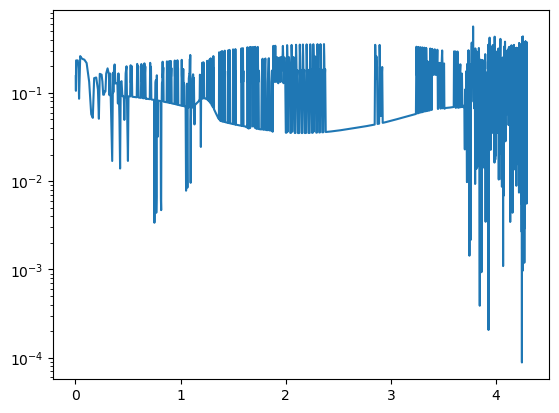

In [119]:
plt.plot(profMS.radius,np.abs(hse/grav.value))
plt.yscale('log')

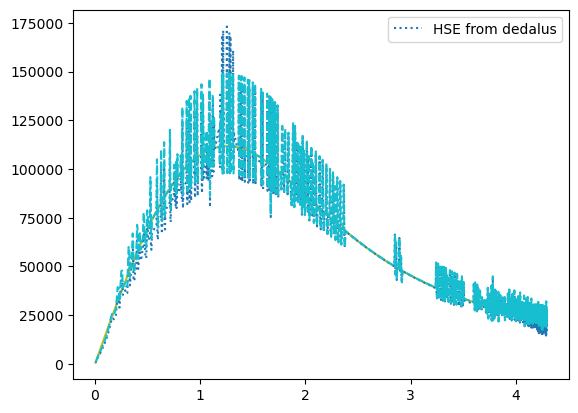

In [122]:
# plt.plot(profMS.radius,np.abs(hse))
# plt.plot(profMS.radius,gamma*pomega)

plt.plot(profMS.radius,-grav.value,c='tab:olive')
# plt.plot(profMS.radius,-(gamma*pomega/profMS.pgas_div_ptotal)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp),label='HSE from dedalus',ls=':',zorder=3) #
plt.plot(profMS.radius,-gamma*pomega*( np.gradient(rho,radius_cgs)/rho + grad_s/cp ),label='HSE from dedalus',ls=':') #
# plt.plot(profMS.radius,-((gamma*P/rho)*np.gradient(rho,radius_cgs)/rho + (gamma/cp)*P*grad_s/rho),label='Chain Rule') # 
plt.plot(profMS.radius,-np.gradient(P,radius_cgs)/rho,ls='--',c='tab:cyan')
#*np.gradient(np.log(rho),radius_cgs)
# plt.plot(profMS.radius,grad_s/cp)
# plt.yscale('log')


plt.legend()
# plt.xscale('log')

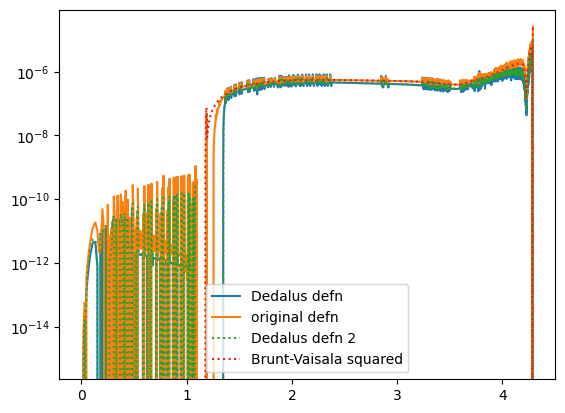

In [58]:
plt.plot(profMS.radius,-(gamma*pomega)*(grad_s/cp + np.gradient(rho,radius_cgs)/rho)*grad_s/cp ,label='Dedalus defn')
# plt.plot(profMS.radius,-(gamma*pomega)*(grad_s/cp + np.gradient(rho,radius_cgs)/rho)*(grad_s/cp + (profMS.pgas_div_ptotal-1)*np.gradient(rho,radius_cgs)/rho) ,label='test')
plt.plot(profMS.radius,-grav.value*((1/gamma)*np.gradient(P,radius_cgs)/P - np.gradient(rho,radius_cgs)/rho),ls='-',label='original defn')
plt.plot(profMS.radius,-grav.value*grad_s/cp,ls=':',label='Dedalus defn 2')
plt.plot(profMS.radius,profMS.brunt_N2,ls=':',label='Brunt-Vaisala squared')
plt.yscale('log')
plt.legend()

Text(0.5, 0, 'Radius')

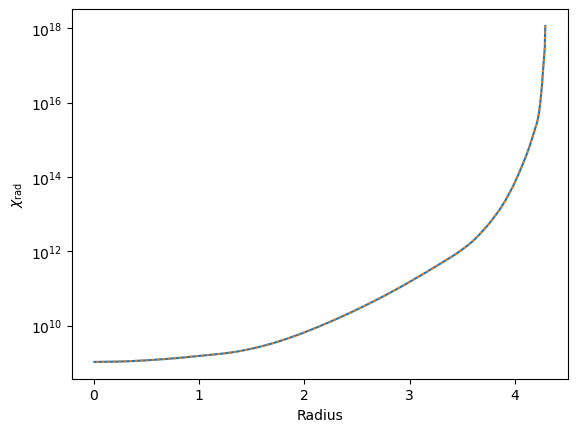

In [61]:
plt.plot(profMS.radius,chi_rad)
plt.plot(profMS.radius,16*constants.sigma_sb.cgs*T**3/(3*rho**2*cp*profMS.opacity),ls=':')
plt.yscale('log')
plt.ylabel(r'$\chi_{\rm rad}$')
plt.xlabel('Radius')

Text(0.5, 0, 'Radius')

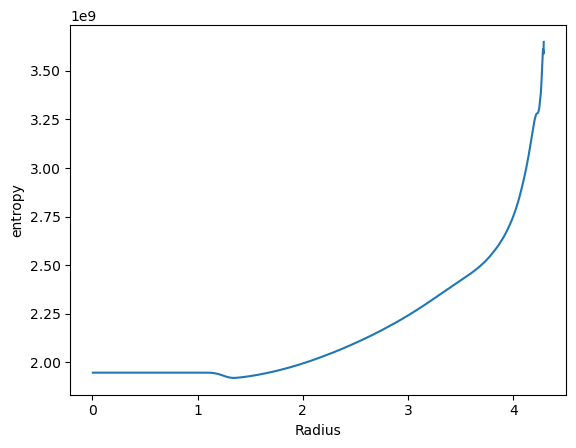

In [62]:
plt.plot(profMS.radius,s)
# plt.yscale('log')
plt.ylabel(r'entropy')
plt.xlabel('Radius')

Text(0.5, 0, 'Radius')

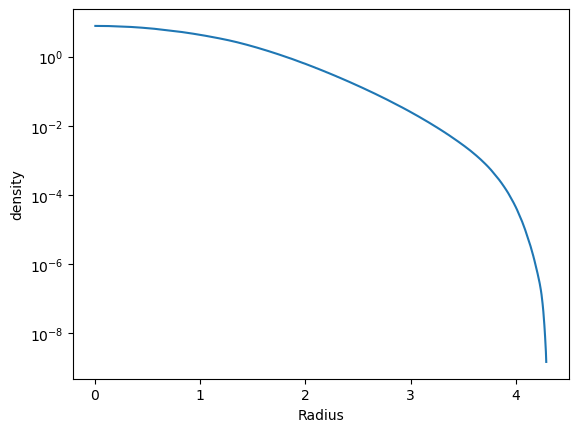

In [63]:
plt.plot(profMS.radius,rho)
plt.yscale('log')
plt.ylabel(r'density')
plt.xlabel('Radius')

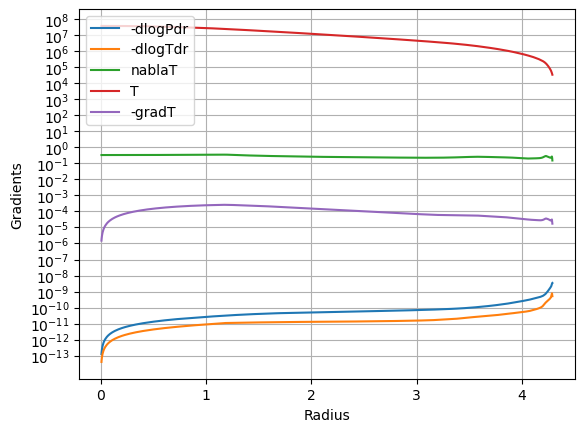

In [64]:
plt.plot(profMS.radius,-dlogPdr,label='-dlogPdr')
plt.plot(profMS.radius,-dlogTdr,label='-dlogTdr')
plt.plot(profMS.radius,nablaT,label='nablaT')
plt.plot(profMS.radius,T,label='T')
plt.plot(profMS.radius,-gradT,label='-gradT')
plt.yscale('log')
plt.ylabel(r'Gradients')
plt.xlabel('Radius')
plt.legend()
plt.yticks(np.logspace(-13,8,22))
plt.grid()

R_gas: 1.33467E+08


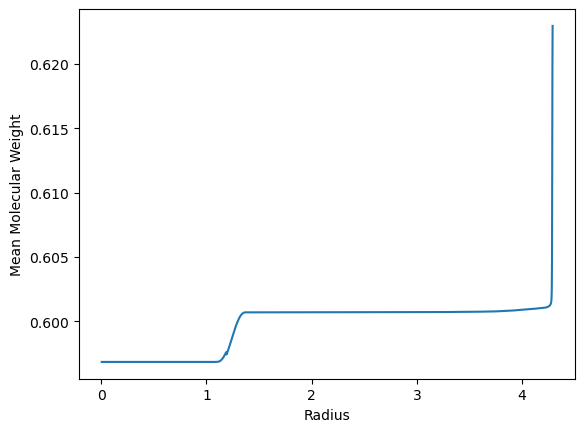

In [68]:
plt.plot(profMS.radius,profMS.mu)
plt.ylabel('Mean Molecular Weight')
plt.xlabel('Radius')
# R_gas = constants.R.cgs/(profMS.mu*u.g/u.mol)[0]
print(f'R_gas: {R_gas[0].value:1.5E}')

Text(0.5, 0, 'Radius')

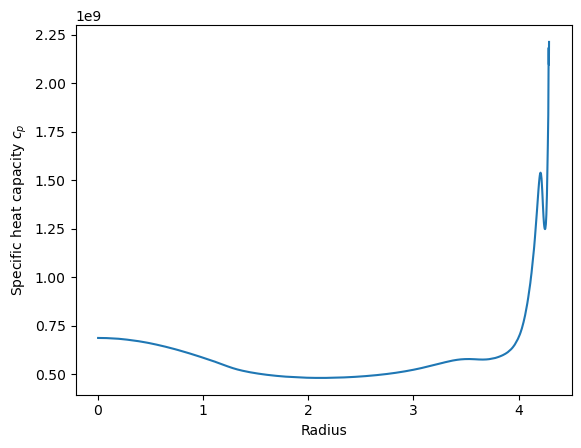

In [69]:
plt.plot(profMS.radius,cp)
plt.ylabel(r'Specific heat capacity $c_p$') 
plt.xlabel('Radius')
# plt.ylim(0,4e9)

Text(0.5, 0, 'Radius')

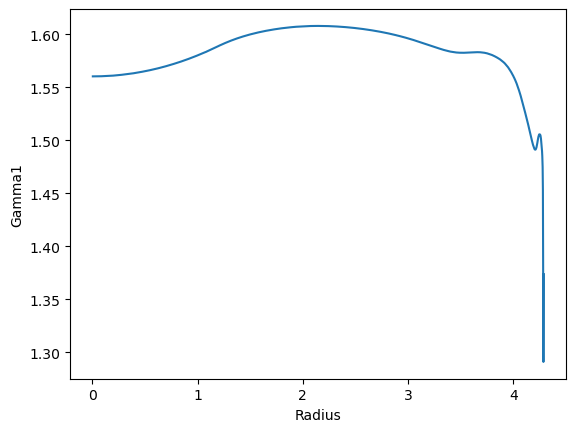

In [70]:
plt.plot(profMS.radius,profMS.gamma1)
plt.ylabel('Gamma1')
plt.xlabel('Radius')

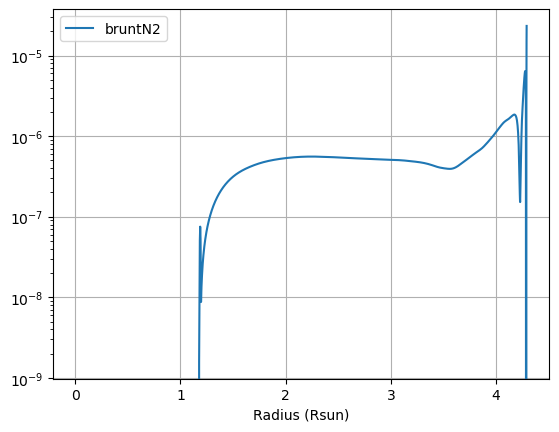

In [31]:
plt.plot(profMS.radius,profMS.brunt_N2,label='bruntN2')
# omega_con = 2*np.pi*profMS.conv_vel/(2*profMS.mlt_mixing_length)
# plt.plot(10**profMS.logR,omega_con**2,label=r'$\omega_{con}^2$')
# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')
# plt.scatter(10**profMS.logR[index_of_radius(0.9,profMS)],omega_con[index_of_radius(0.9,profMS)]**2,label='0.9Rsun',color='salmon')
# plt.scatter(10**profMS.logR[index_of_radius(1.2,profMS)],profMS.brunt_N2[index_of_radius(1.2,profMS)],label='2Rsun',color='salmon')
plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
# plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')
plt.grid()

# 12 Msun

what we need from mesa: density, temperature, entropy, Cp, viscosity, entropy gradient, diffusivities, Q = div(Fconv_0) = nuclear burning + div(radiative flux)

for temperature to adjust, want Q to be able to change in time (not remain a fixed function of r) - otherwise will not get CP

In [20]:
log=mr.MesaLogDir('/carnegie/nobackup/users/swu/mesa_r24.03.1_workdir/12M_pre_ms_to_core_collapse/LOGS_hires_test3')
h = log.history


In [21]:
log.profile_numbers

array([1, 2, 3, 4, 5, 6, 7])

In [22]:
log.profile_data(profile_number=1).bulk_names

('zone',
 'mass',
 'logR',
 'logT',
 'logRho',
 'logP',
 'x_mass_fraction_H',
 'y_mass_fraction_He',
 'z_mass_fraction_metals',
 'dm',
 'logdq',
 'dq_ratio',
 'q',
 'vel_km_per_s',
 'radius',
 'radius_cm',
 'logR_cm',
 'rmid',
 'velocity',
 'v_div_r',
 'pressure_scale_height',
 'mmid',
 'logxq',
 'dr',
 'log_dr',
 'dr_div_cs',
 'log_dr_div_cs',
 'acoustic_depth',
 'log_cell_collapse_time',
 'temperature',
 'energy',
 'logE',
 'rho',
 'entropy',
 'pressure',
 'logPgas',
 'pgas_div_ptotal',
 'eta',
 'mu',
 'grada',
 'cv',
 'cp',
 'gamma1',
 'free_e',
 'chiRho',
 'chiT',
 'csound',
 'log_csound',
 'v_div_csound',
 'eps_grav',
 'eps_nuc',
 'non_nuc_neu',
 'pp',
 'cno',
 'tri_alpha',
 'c_alpha',
 'n_alpha',
 'o_alpha',
 'ne_alpha',
 'na_alpha',
 'mg_alpha',
 'si_alpha',
 's_alpha',
 'ar_alpha',
 'ca_alpha',
 'ti_alpha',
 'cr_alpha',
 'fe_co_ni',
 'c12_c12',
 'c12_o16',
 'o16_o16',
 'pnhe4',
 'photo',
 'ni56_co56',
 'co56_fe56',
 'other',
 'abar',
 'zbar',
 'z2bar',
 'ye',
 'x',
 'y',
 'z',


Text(0.5, 0, 'Mass')

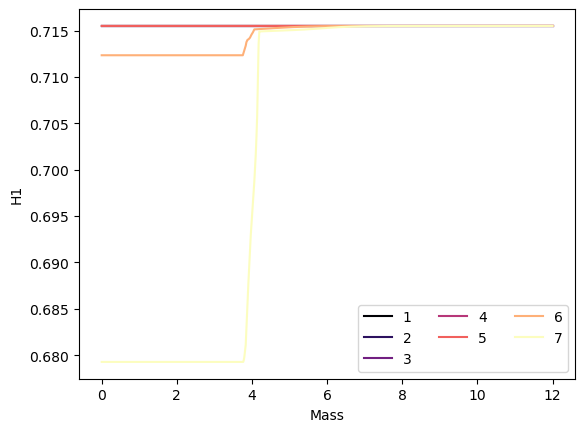

In [70]:
cs = plt.cm.magma(np.linspace(0,1,len(log.profile_numbers)))

for i,num in enumerate(log.profile_numbers):
    prof = log.profile_data(profile_number=num)
    plt.plot(prof.mass,prof.h1,color=cs[i],label=num)
plt.legend(ncol=3)
plt.ylabel('H1')
plt.xlabel('Mass')

## Main Sequence

In [23]:
profMS = log.profile_data(profile_number=6)

### Quantities needed for compressible_stars in Dedalus

In [6]:
profMS.photosphere_r

4.173610084341328

In [7]:
from astropy import constants
from astropy import units as u
from scipy.interpolate import interp1d
# profMS.gamma1, profMS.entropy, profMS,rho, profMS.luminosity, profMS.conv_L_div_L, profMS.gradT, constants.R.cgs, profMS.mu*u.g/u.mol, constants.G.cgs*profMs.mass/profMS.radius**2

In [15]:
gamma = profMS.gamma1
# s = (profMS.entropy*constants.N_A*constants.k_B.cgs).value


R_gas = constants.R.cgs/(profMS.mu[-1]*u.g/u.mol) #want innermost value of mu eventually
cp = profMS.cp #R_gas.value*profMS.gamma1/(profMS.gamma1-1)


rho = profMS.rho
P = profMS.pressure
T = profMS.temperature
radius_cgs = profMS.radius_cm
grav = -constants.G.cgs*profMS.mass*Msun/radius_cgs**2
N2 = profMS.brunt_N2
grad_s_over_cp = N2/(-grav.value)
grad_s = cp*grad_s_over_cp

L = profMS.luminosity*Lsun
Lconv = profMS.lum_conv_div_L*profMS.luminosity*Lsun
nablaT = profMS.gradT

dlogPdr = -rho*(-grav.value)/P
dlogTdr = nablaT*dlogPdr
gradT = dlogTdr*T

chi_rad = -(L-Lconv)/gradT/(4*np.pi*radius_cgs**2)/rho/cp

pomega = R_gas.value*T

hse = (gamma*pomega)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega

# hse = (gamma*pomega/profMS.pgas_div_ptotal)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega

In [16]:
conv_core_condition = (Lconv>1)*(profMS.mass < 0.9*profMS.mass[0])
# print(profMS.mass[conv_core_condition][0])
core_index = np.argmin(np.abs(profMS.mass-profMS.mass[conv_core_condition][0]))
# print(profMS.mass[core_index])
core_cz_radius = radius_cgs[core_index]
# print(core_cz_radius/Rsun)
brunt_N2_max = np.amax(profMS.brunt_N2[profMS.mass < profMS.mass[0]*0.95])
brunt_N2_maxind = np.argmin(np.abs(profMS.brunt_N2-brunt_N2_max))

f_brunt = np.sqrt(brunt_N2_max)/(2*np.pi)


L_CZ    = core_cz_radius
m_core  = rho[-1] * L_CZ**3
T_core  = T[-1]
H0      = (rho*profMS.eps_nuc)[-1]
print(m_core/Msun,f'{T_core:1.2E}',f'{H0:1.2E}')
tau_heat  = ((H0*L_CZ/m_core)**(-1/3)) #heating timescale
L_nd    = L_CZ
m_nd    = rho[radius_cgs==L_nd][-1] * L_nd**3 #mass at core cz boundary
T_nd    = T[radius_cgs==L_nd][-1] #temp at core cz boundary
# tau_nd  = (1/f_brunt) #timescale of max N^2
tau_nd = 9.39e+03 #s #just make it match for now to check something
rho_nd  = m_nd/L_nd**3
u_nd    = L_nd/tau_nd
s_nd    = L_nd**2 / tau_nd**2 / T_nd
H_nd    = (m_nd / L_nd) * tau_nd**-3
s_motions    = L_nd**2 / tau_heat**2 / T[-1]
lum_nd  = L_nd**2 * m_nd / (tau_nd**2) / tau_nd
nondim_R_gas = (R_gas / s_nd).cgs.value
nondim_gamma1 = (gamma[-1])
nondim_cp = nondim_R_gas * nondim_gamma1 / (nondim_gamma1 - 1)
u_heat_nd = (L_nd/tau_heat) / u_nd
Ma2_r0 = ((u_nd*(tau_nd/tau_heat))**2 / ((gamma[-1]-1)*cp[-1]*T[-1]))
print('Nondimensionalization: L_nd = {:.2e}, T_nd = {:.2e}, m_nd = {:.2e}, tau_nd = {:.2e}'.format(L_nd, T_nd, m_nd, tau_nd))
print('Thermo: Cp/s_nd: {:.2e}, R_gas/s_nd: {:.2e}, gamma1: {:.4f}'.format(nondim_cp, nondim_R_gas, nondim_gamma1))
print(r'm_nd/M$_\odot$: {:.3f}'.format((m_nd*u.g/constants.M_sun).cgs))
print('estimated mach number: {:.3e} / t_heat: {:.3e}'.format(np.sqrt(Ma2_r0), tau_heat))

#for the star_builder.py f'n, the entropy background comes from HSE_solve. only load in grad_s0 since that's the only thing that appears in eq'ns
# s = cp * ((1/gamma)*(np.log(pomega) + np.log(rho)) - np.log(rho))
# s0 = s/s_nd # nondimensionalize?
pom0 = pomega/s_nd/T_nd
ln_rho0 = np.log(rho/rho_nd)
s0 = nondim_cp*((1/nondim_gamma1)*(np.log(pom0)+ln_rho0) - ln_rho0)
eos = s0/nondim_cp - ( (1/nondim_gamma1) * (np.log(pom0) - np.log(nondim_R_gas)) - ((nondim_gamma1-1)/nondim_gamma1) * ln_rho0 )


1.3253230205600488 3.32E+07 3.63E+05
Nondimensionalization: L_nd = 6.88e+10, T_nd = 2.28e+07, m_nd = 1.33e+33, tau_nd = 9.39e+03
Thermo: Cp/s_nd: 1.58e+02, R_gas/s_nd: 5.78e+01, gamma1: 1.5763
m_nd/M$_\odot$: 0.669
estimated mach number: 1.375e-03 / t_heat: 4.725e+05


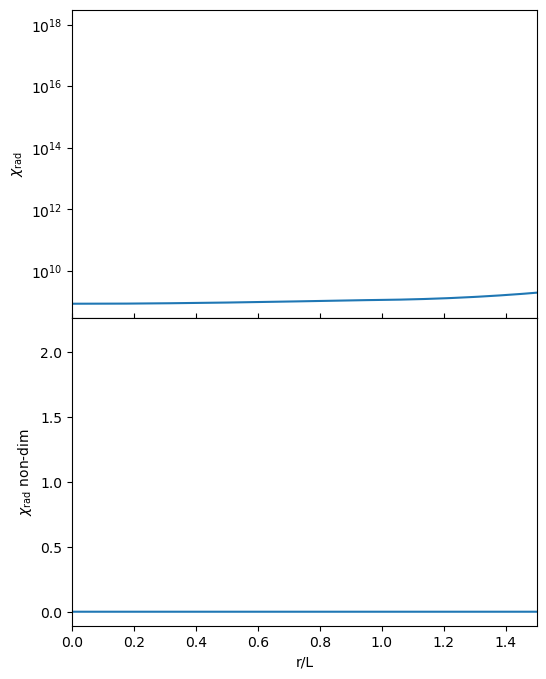

In [17]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,chi_rad)
ax[1].plot(radius_cgs/L_nd,chi_rad * (tau_nd / L_nd**2))

ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\chi_{\rm rad}$')
ax[1].set_ylabel(r'$\chi_{\rm rad}$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)

for i in range(2):
    ax[i].set_xlim(0,1.5)
plt.subplots_adjust(hspace=0)

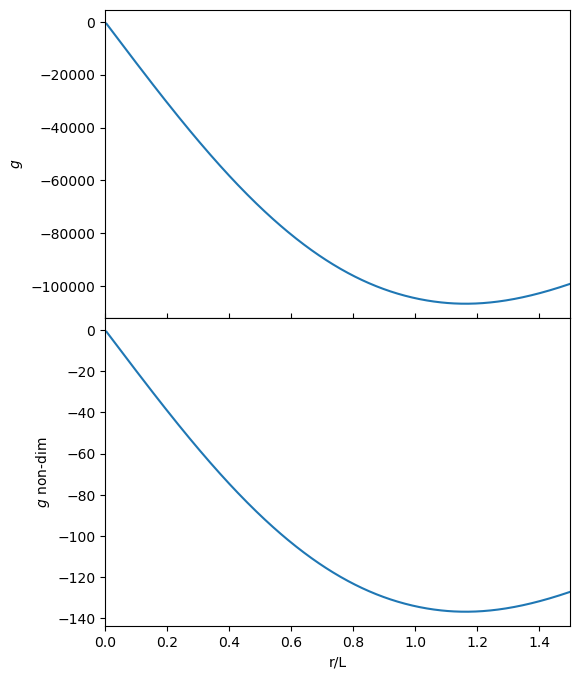

In [18]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,grav.value)
ax[1].plot(radius_cgs/L_nd,grav.value * (tau_nd**2/L_nd))

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$g$')
ax[1].set_ylabel(r'$g$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
for i in range(2):
    ax[i].set_xlim(0,1.5)
plt.subplots_adjust(hspace=0)

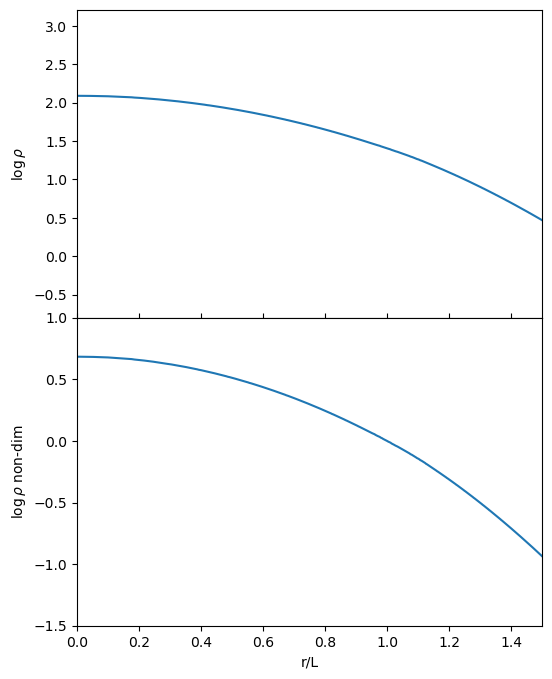

In [12]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,np.log(rho))
ax[1].plot(radius_cgs/L_nd,np.log(rho/rho_nd))

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\log\rho$')
ax[1].set_ylabel(r'$\log\rho$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
ax[1].set_ylim(-1.5,1)
ax[0].set_ylim(-0.8,)
for i in range(2):
    ax[i].set_xlim(0,1.5)
    
plt.subplots_adjust(hspace=0)

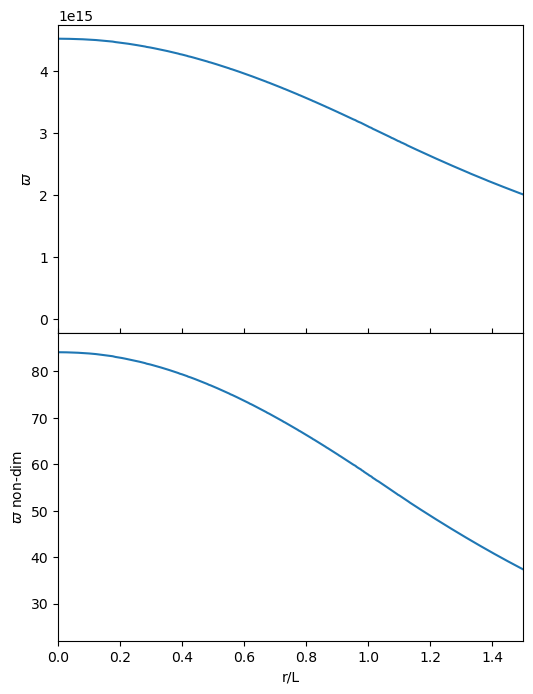

In [13]:
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].plot(radius_cgs/L_nd,pomega)
ax[1].plot(radius_cgs/L_nd,pom0)

# ax[0].set_yscale('log')
ax[1].set_xlabel('r/L')
ax[0].set_ylabel(r'$\varpi$')
ax[1].set_ylabel(r'$\varpi$ non-dim')
ax[0].tick_params(axis='x',direction='in',labelbottom=False)
# ax[1].set_ylim(-1.5,1)
ax[1].set_ylim(22,)
for i in range(2):
    ax[i].set_xlim(0,1.5)
    
plt.subplots_adjust(hspace=0)

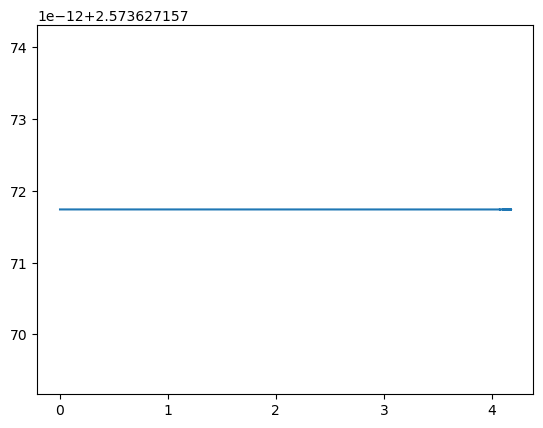

In [14]:
plt.plot(profMS.radius,eos)

### other plots

In [72]:
gamma = profMS.gamma1
# s = (profMS.entropy*constants.N_A*constants.k_B.cgs).value

R_gas = constants.R.cgs/(profMS.mu*u.g/u.mol) #want innermost value of mu eventually
cp = profMS.cp #R_gas.value*profMS.gamma1/(profMS.gamma1-1)


rho = profMS.rho
P = profMS.pressure
T = profMS.temperature
radius_cgs = profMS.radius_cm
grav = -constants.G.cgs*profMS.mass*Msun/radius_cgs**2
N2 = profMS.brunt_N2
grad_s_over_cp = N2/(-grav.value)
grad_s = cp*grad_s_over_cp

L = profMS.luminosity*Lsun
Lconv = profMS.conv_L_div_L*profMS.luminosity*Lsun
nablaT = profMS.gradT

dlogPdr = -rho*(-grav.value)/P
dlogTdr = nablaT*dlogPdr
gradT = dlogTdr*T

chi_rad = -(L-Lconv)/gradT/(4*np.pi*radius_cgs**2)/rho/cp

pomega = R_gas.value*T


hse = (gamma*pomega)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega
hse2 = (gamma*pomega/profMS.pgas_div_ptotal)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp) - grav.value #since g is already nega

with lores, Large errors in HSE in the envelope -something makes the pressure different? tended to be fixed in the core by pgas/ptot \
for hires, no more large errors in envelope but some in core - could also be fixed by pgas/ptot but that messes up envelope

In [48]:

density_interp = interp1d(radius_cgs,rho)
entropy_interp = interp1d(radius_cgs,s)
logRmin = np.log10(profMS.radius_cm[-2])
logRmax = np.log10(profMS.radius_cm[1])
density_for_derivative = density_interp(np.logspace(logRmin,logRmax,10000))

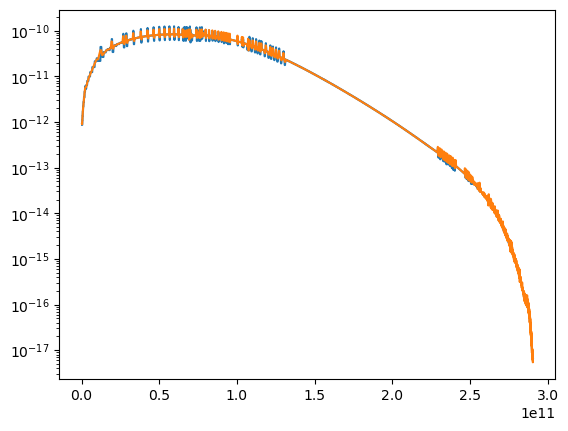

In [49]:
# plt.plot(np.logspace(logRmin,logRmax,10000),density_for_derivative)
plt.plot( np.logspace(logRmin,logRmax,10000),-np.gradient(density_for_derivative,np.logspace(logRmin,logRmax,10000)))
plt.plot(radius_cgs,-np.gradient(rho,radius_cgs))
plt.yscale('log')

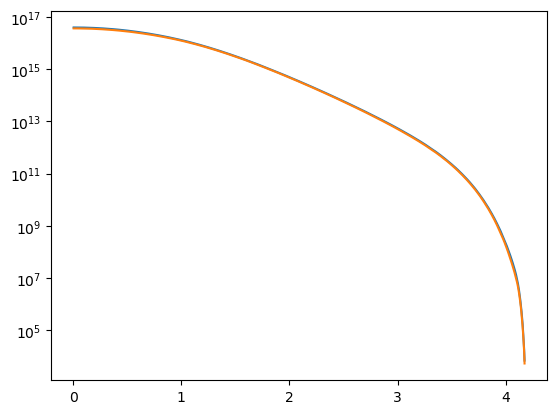

In [50]:
plt.plot(profMS.radius,profMS.pressure,label='Pressure')
plt.plot(profMS.radius,profMS.pgas_div_ptotal*profMS.pressure,label='Gas Pressure')
plt.yscale('log')

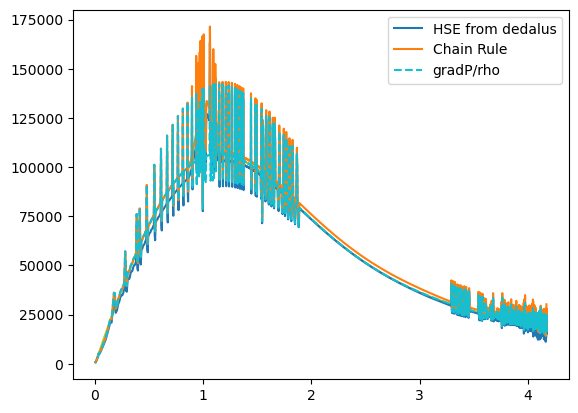

In [73]:
# plt.plot(profMS.radius,np.abs(hse))
# plt.plot(profMS.radius,gamma*pomega)

plt.plot(profMS.radius,-grav.value,c='tab:olive')
# plt.plot(profMS.radius,-(gamma*pomega/profMS.pgas_div_ptotal)*(np.gradient(rho,radius_cgs)/rho+grad_s/cp),label='HSE from dedalus',ls=':',zorder=3) #
plt.plot(profMS.radius,-gamma*pomega*( np.gradient(rho,radius_cgs)/rho + grad_s/cp ),label='HSE from dedalus')
plt.plot(profMS.radius,-((gamma*P/rho)*np.gradient(rho,radius_cgs)/rho + (gamma/cp)*P*grad_s/rho),label='Chain Rule') # 
plt.plot(profMS.radius,-np.gradient(P,radius_cgs)/rho,ls='--',c='tab:cyan',label='gradP/rho')
#*np.gradient(np.log(rho),radius_cgs)
# plt.plot(profMS.radius,grad_s/cp)
# plt.yscale('log')


plt.legend()
# plt.xscale('log')

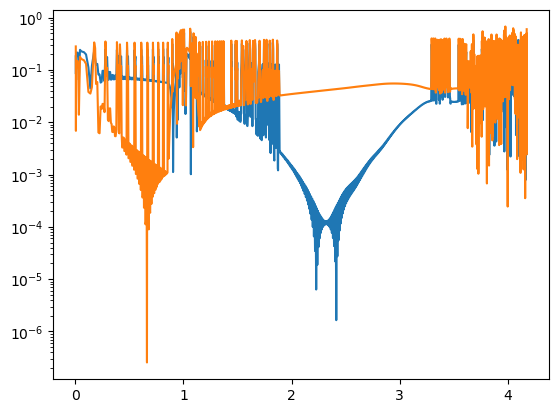

In [74]:
plt.plot(profMS.radius,np.abs(hse/grav.value))
plt.plot(profMS.radius,np.abs(hse2/grav.value))
plt.yscale('log')

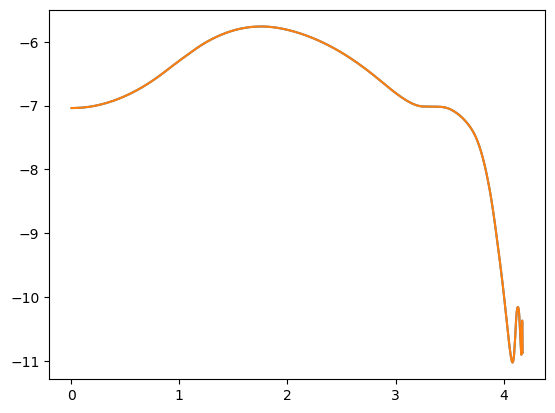

In [118]:
eos = (s/cp - ( (1/gamma) * (np.log(pomega) - np.log(R_gas.value)) - ((gamma-1)/gamma) * np.log(rho) ))
eos2 = s/cp - ( (1/gamma) * np.log(T) - ((gamma-1)/gamma) * np.log(rho)) 
# eos3 = s/cp - ( (1/gamma) * np.log(P) -  np.log(rho) )
plt.plot(profMS.radius,eos)
plt.plot(profMS.radius,eos2)

# plt.plot(profMS.radius,eos3)

# plt.plot(profMS.radius,profMS.pgas_div_ptotal)

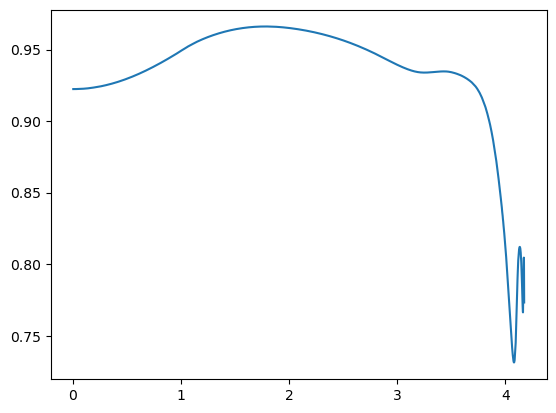

In [109]:
plt.plot(profMS.radius,profMS.pgas_div_ptotal)
# plt.plot(profMS.radius,1-profMS.pgas_div_ptotal)

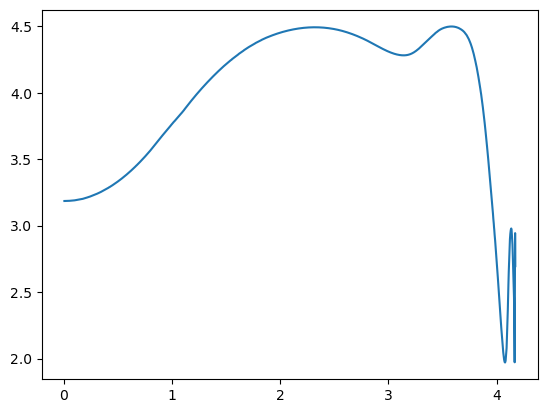

In [105]:
plt.plot(profMS.radius,s/cp)

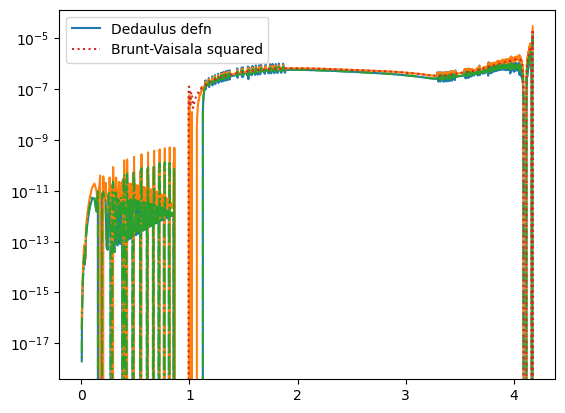

In [54]:
plt.plot(profMS.radius,-(gamma*pomega)*(grad_s/cp + np.gradient(rho,radius_cgs)/rho)*grad_s/cp ,label='Dedaulus defn')
# plt.plot(profMS.radius,-(gamma*pomega)*(grad_s/cp + np.gradient(rho,radius_cgs)/rho)*(grad_s/cp + (profMS.pgas_div_ptotal-1)*np.gradient(rho,radius_cgs)/rho) ,label='test w/Pgas')
plt.plot(profMS.radius,-grav.value*((1/gamma)*np.gradient(P,radius_cgs)/P - np.gradient(rho,radius_cgs)/rho),ls='-')
plt.plot(profMS.radius,-grav.value*grad_s/cp,ls='-.')
plt.plot(profMS.radius,profMS.brunt_N2,ls=':',label='Brunt-Vaisala squared')
plt.yscale('log')
plt.legend()

Text(0.5, 0, 'Radius')

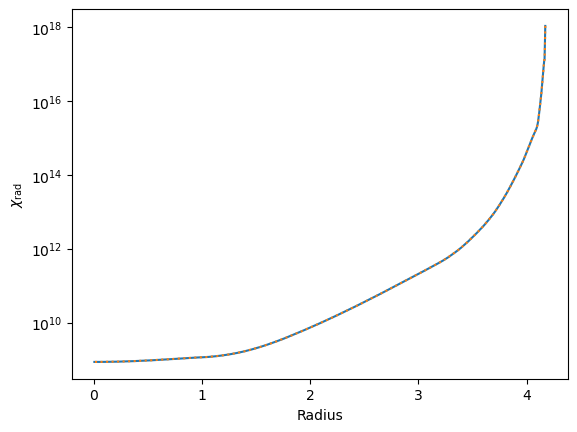

In [55]:
plt.plot(profMS.radius,chi_rad)
plt.plot(profMS.radius,16*constants.sigma_sb.cgs*T**3/(3*rho**2*cp*profMS.opacity),ls=':')
plt.yscale('log')
plt.ylabel(r'$\chi_{\rm rad}$')
plt.xlabel('Radius')

In [67]:
1e11/Rsun

1.4367816091954022

Text(0.5, 0, 'Radius')

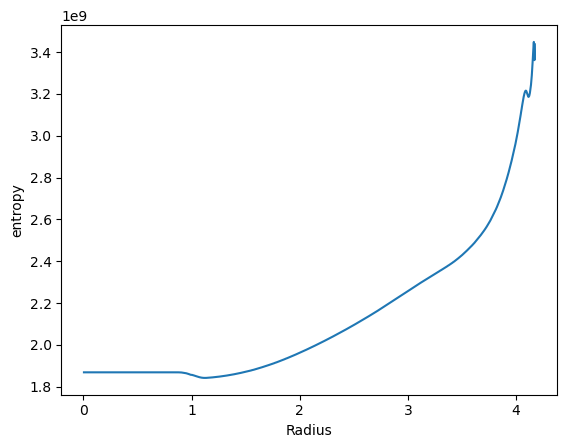

In [56]:
plt.plot(profMS.radius,s)
# plt.yscale('log')
plt.ylabel(r'entropy')
plt.xlabel('Radius')

Text(0.5, 0, 'Radius')

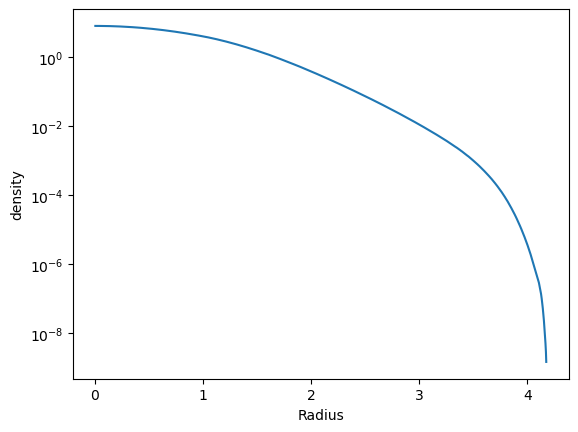

In [57]:
plt.plot(profMS.radius,rho)
plt.yscale('log')
plt.ylabel(r'density')
plt.xlabel('Radius')

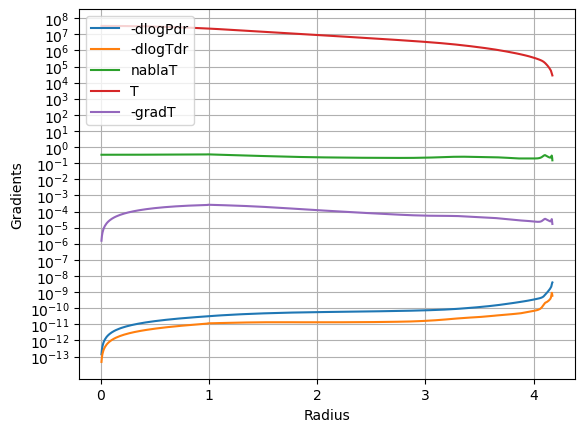

In [58]:
plt.plot(profMS.radius,-dlogPdr,label='-dlogPdr')
plt.plot(profMS.radius,-dlogTdr,label='-dlogTdr')
plt.plot(profMS.radius,nablaT,label='nablaT')
plt.plot(profMS.radius,T,label='T')
plt.plot(profMS.radius,-gradT,label='-gradT')
plt.yscale('log')
plt.ylabel(r'Gradients')
plt.xlabel('Radius')
plt.legend()
plt.yticks(np.logspace(-13,8,22))
plt.grid()

R_gas: 1.29521E+08 erg / (K g)


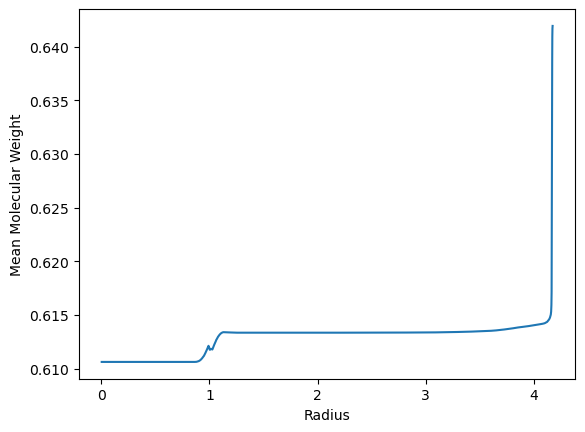

In [59]:
plt.plot(profMS.radius,profMS.mu)
plt.ylabel('Mean Molecular Weight')
plt.xlabel('Radius')
# R_gas = constants.R.cgs/(profMS.mu*u.g/u.mol)[0]
print(f'R_gas: {R_gas[0]:1.5E}')

Text(0.5, 0, 'Radius')

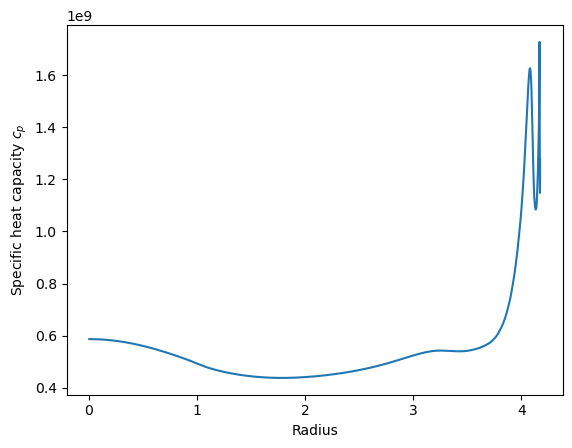

In [60]:
plt.plot(profMS.radius,cp)
plt.ylabel(r'Specific heat capacity $c_p$') 
plt.xlabel('Radius')
# plt.ylim(0,4e9)

Text(0.5, 0, 'Radius')

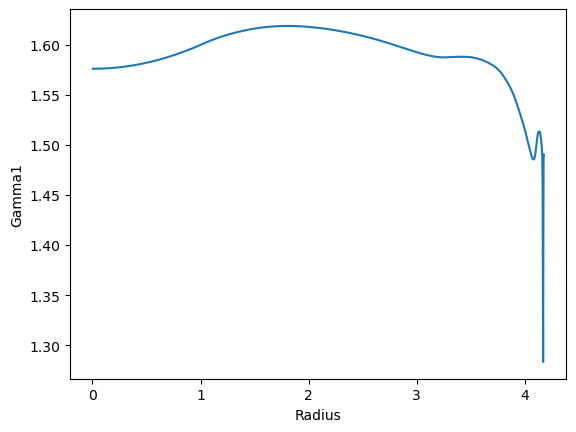

In [61]:
plt.plot(profMS.radius,profMS.gamma1)
plt.ylabel('Gamma1')
plt.xlabel('Radius')

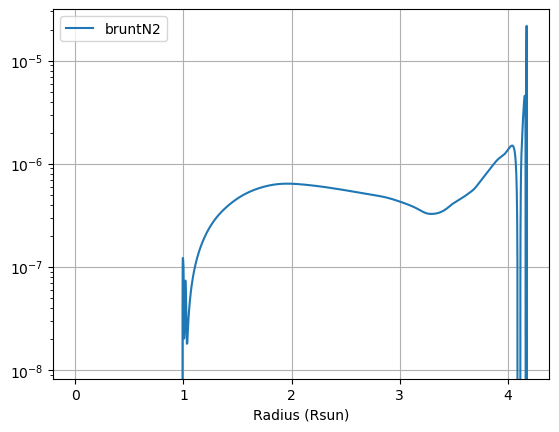

In [62]:
plt.plot(10**profMS.logR,profMS.brunt_N2,label='bruntN2')
# omega_con = 2*np.pi*profMS.conv_vel/(2*profMS.mlt_mixing_length)
# plt.plot(10**profMS.logR,omega_con**2,label=r'$\omega_{con}^2$')
# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')
# plt.scatter(10**profMS.logR[index_of_radius(0.9,profMS)],omega_con[index_of_radius(0.9,profMS)]**2,label='0.9Rsun',color='salmon')
# plt.scatter(10**profMS.logR[index_of_radius(1.2,profMS)],profMS.brunt_N2[index_of_radius(1.2,profMS)],label='2Rsun',color='salmon')
plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
# plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')
plt.grid()

### other stuff

In [24]:
np.sort(profMS.bulk_names)


array(['P_face', 'RTI_du_diffusion_kick', 'abar', 'acoustic_depth',
       'alpha_RTI', 'am_log_D_DSI', 'am_log_D_ES', 'am_log_D_GSF',
       'am_log_D_SH', 'am_log_D_SSI', 'am_log_D_ST', 'am_log_nu_ST',
       'am_log_sig', 'ar36', 'ar_alpha', 'boost_for_eta_RTI', 'brunt_N2',
       'brunt_N2_composition_term', 'brunt_N2_structure_term', 'c12',
       'c12_c12', 'c12_o16', 'c_alpha', 'ca40', 'ca_alpha', 'chiRho',
       'chiT', 'cno', 'co56', 'co56_fe56', 'conv_L_div_L', 'conv_vel',
       'conv_vel_div_csound', 'cp', 'cr48', 'cr60', 'cr_alpha', 'csound',
       'cv', 'dPdr_dRhodr_info', 'dPdr_info', 'dRhodr_info', 'dedt_RTI',
       'dlogR', 'dm', 'dq_ratio', 'dr', 'dr_div_cs', 'dudt_RTI',
       'dynamo_log_B_phi', 'dynamo_log_B_r', 'energy', 'entropy',
       'eps_grav', 'eps_nuc', 'eta', 'eta_RTI', 'extra_heat',
       'extra_opacity_factor', 'fe52', 'fe54', 'fe56', 'fe_co_ni',
       'fp_rot', 'free_e', 'ft_rot', 'gamma1', 'gradT', 'gradT_sub_grada',
       'grada', 'gradr', 'h1'

In [25]:
r_out = 6.88e+10*1.4/Rsun
print(r_out)

1.3839080459770114


Text(0, 0.5, 'opacity')

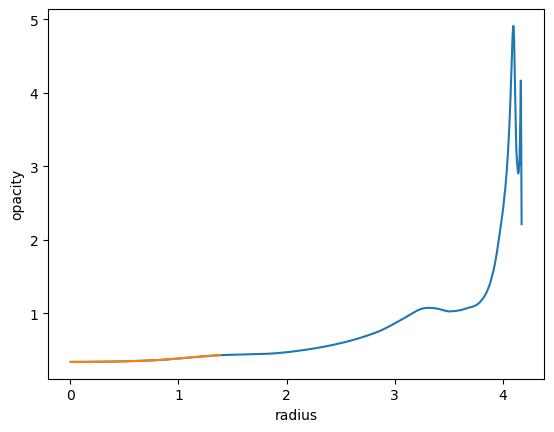

In [26]:
plt.plot(profMS.radius,profMS.opacity)
plt.plot(profMS.radius[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('radius')
plt.ylabel('opacity')
# plt.axvline(r_out)

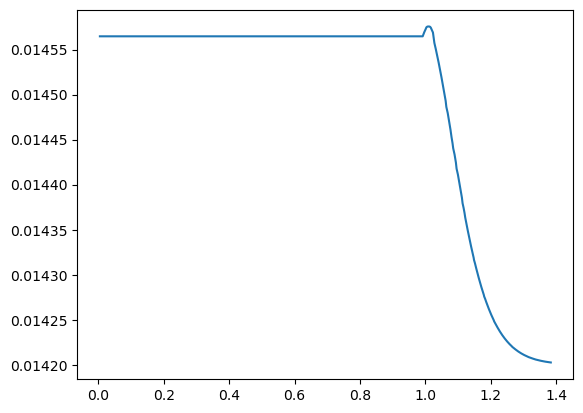

In [27]:
# plt.plot(profMS.radius[profMS.radius<r_out],profMS.x[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],profMS.z[profMS.radius<r_out])

opacity

Text(0, 0.5, 'opacity')

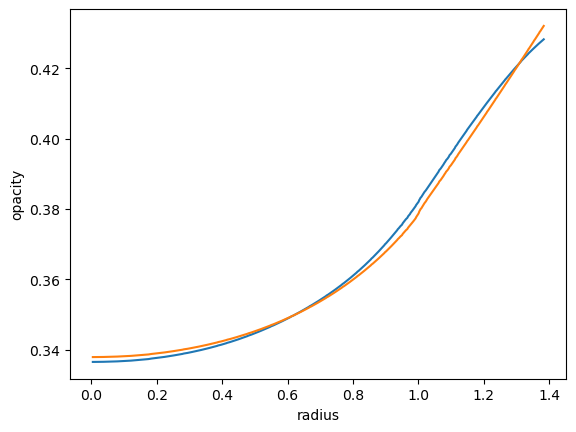

In [28]:
r_out = 6.88e+10*1.4/Rsun

kappa_ff = lambda rho,T,Z,X: 3.68e22*(1-Z)*(1+X)*rho*T**(-7/2)
kappa_bf = lambda rho,T,Z,X: 4.34e25*Z*(1+X)*rho*T**(-7/2)
gff=22
gbf=1e-4
plt.plot(profMS.radius[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.plot(profMS.radius[profMS.radius<r_out],0.2*(1+profMS.x[profMS.radius<r_out])+gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],
        profMS.ye[profMS.radius<r_out]*(0.2*(1+profMS.x[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out]) )
# plt.plot(profMS.radius[profMS.radius<r_out],
#         profMS.ye[profMS.radius<r_out]*(0.2*(1+profMS.x[profMS.radius<r_out])+gff*kappa_ff(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out]) 
#         + (1-profMS.ye[profMS.radius<r_out])*gbf*kappa_bf(profMS.rho,profMS.temperature,profMS.z,profMS.x)[profMS.radius<r_out])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('radius')
plt.ylabel('opacity')

Text(0, 0.5, 'opacity')

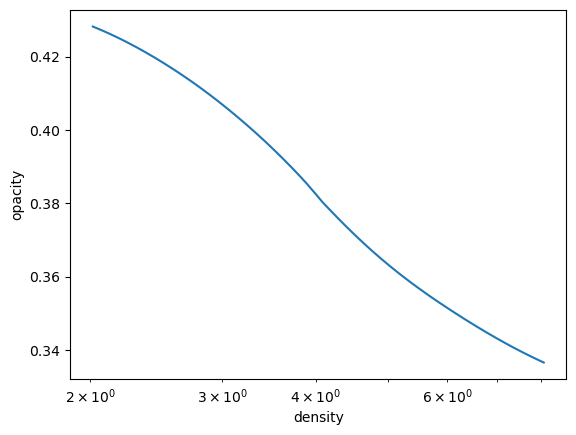

In [29]:
plt.plot(profMS.rho[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(10,1e-10)
plt.xlabel('density')
plt.ylabel('opacity')
# plt.axhline(0.35)

Text(0, 0.5, 'opacity')

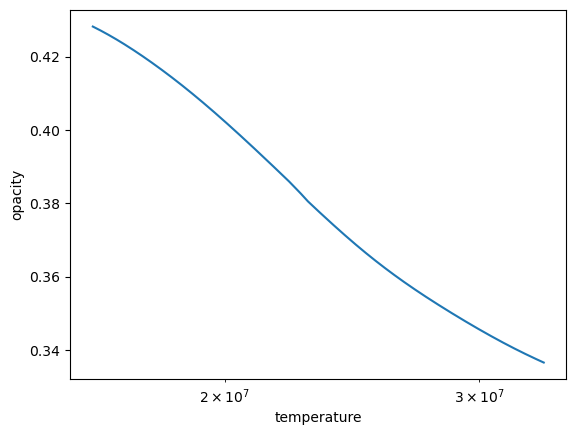

In [30]:
plt.plot(profMS.temperature[profMS.radius<r_out],profMS.opacity[profMS.radius<r_out])
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(10,1e-10)
plt.xlabel('temperature')
plt.ylabel('opacity')

In [40]:
profMS.bulk_names

('zone',
 'mass',
 'logR',
 'logT',
 'logRho',
 'logP',
 'x_mass_fraction_H',
 'y_mass_fraction_He',
 'z_mass_fraction_metals',
 'dm',
 'logdq',
 'dq_ratio',
 'q',
 'vel_km_per_s',
 'radius',
 'radius_cm',
 'logR_cm',
 'rmid',
 'velocity',
 'v_div_r',
 'pressure_scale_height',
 'mmid',
 'logxq',
 'dr',
 'log_dr',
 'dr_div_cs',
 'log_dr_div_cs',
 'acoustic_depth',
 'log_cell_collapse_time',
 'temperature',
 'energy',
 'logE',
 'rho',
 'entropy',
 'pressure',
 'logPgas',
 'pgas_div_ptotal',
 'eta',
 'mu',
 'grada',
 'cv',
 'cp',
 'gamma1',
 'free_e',
 'chiRho',
 'chiT',
 'csound',
 'log_csound',
 'v_div_csound',
 'eps_grav',
 'eps_nuc',
 'non_nuc_neu',
 'pp',
 'cno',
 'tri_alpha',
 'c_alpha',
 'n_alpha',
 'o_alpha',
 'ne_alpha',
 'na_alpha',
 'mg_alpha',
 'si_alpha',
 's_alpha',
 'ar_alpha',
 'ca_alpha',
 'ti_alpha',
 'cr_alpha',
 'fe_co_ni',
 'c12_c12',
 'c12_o16',
 'o16_o16',
 'pnhe4',
 'photo',
 'ni56_co56',
 'co56_fe56',
 'other',
 'abar',
 'zbar',
 'z2bar',
 'ye',
 'x',
 'y',
 'z',


Text(0, 0.5, 'x')

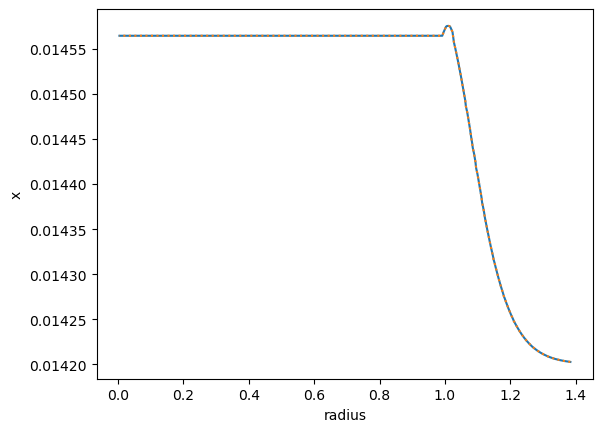

In [42]:
plt.plot(profMS.radius[profMS.radius<r_out],profMS.z[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],
         1-profMS.h1[profMS.radius<r_out]-profMS.he4[profMS.radius<r_out]-profMS.he3[profMS.radius<r_out],
         ls=':')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(10,1e-10)
plt.xlabel('radius')
plt.ylabel('z')

Text(0, 0.5, 'x')

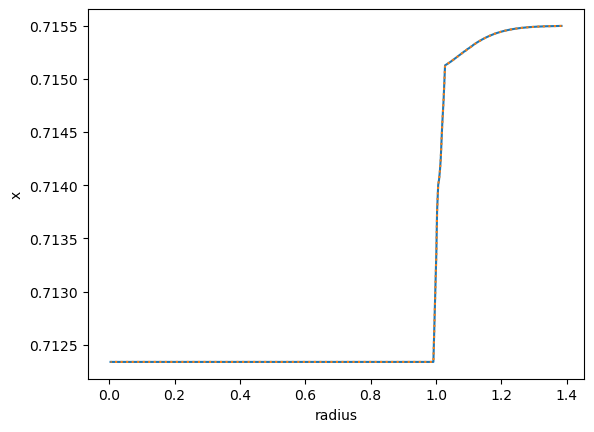

In [38]:
plt.plot(profMS.radius[profMS.radius<r_out],profMS.x[profMS.radius<r_out])
plt.plot(profMS.radius[profMS.radius<r_out],profMS.h1[profMS.radius<r_out],ls=':')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(10,1e-10)
plt.xlabel('radius')
plt.ylabel('x')

Text(0.5, 0, 'Mass (Msun)')

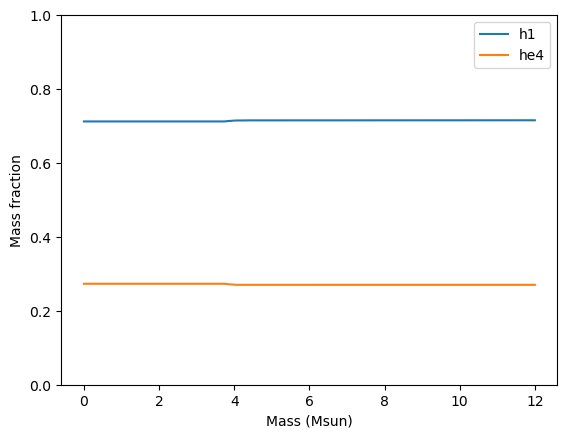

In [6]:
plt.plot(profMS.mass,profMS.h1,label='h1')
plt.plot(profMS.mass,profMS.he4,label='he4')
plt.ylim(0,1)
plt.legend()
plt.ylabel('Mass fraction')
plt.xlabel('Mass (Msun)')

Text(0.5, 0, 'Radius (Rsun)')

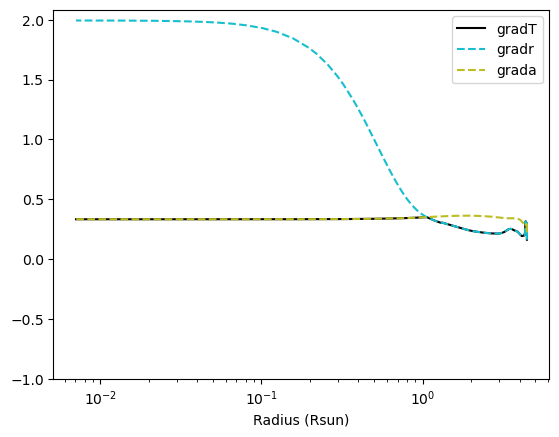

In [53]:
plt.plot(10**profMS.logR,profMS.gradT,label='gradT',c='black')
plt.plot(10**profMS.logR,profMS.gradr,label='gradr',ls='--',c='tab:cyan')
plt.plot(10**profMS.logR,profMS.grada,label='grada',ls="--",c='tab:olive')
# plt.yscale('log')
# plt.ylim(0,1)
plt.ylim(-1,)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

Text(0.5, 0, 'Radius (Rsun)')

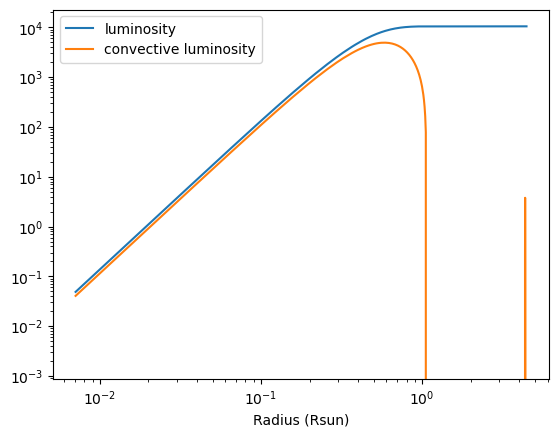

In [39]:
plt.plot(10**profMS.logR,10**profMS.logL,label='luminosity')
plt.plot(10**profMS.logR,profMS.conv_L_div_L*10**profMS.logL,label='convective luminosity')
plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1,)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

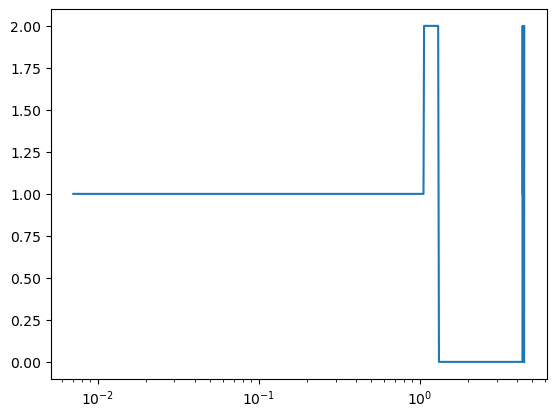

In [8]:
plt.plot(10**profMS.logR,profMS.mixing_type)
plt.xscale('log')

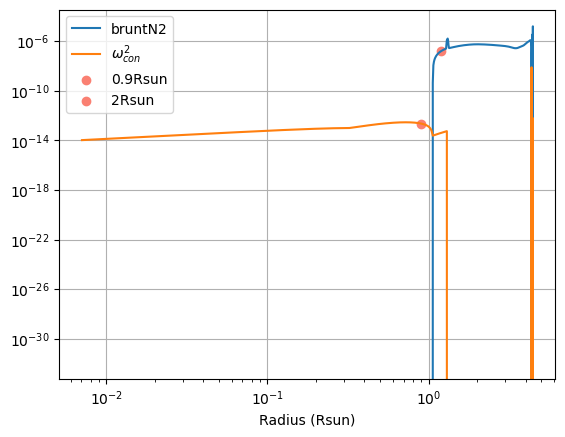

In [104]:
plt.plot(10**profMS.logR,profMS.brunt_N2,label='bruntN2')
omega_con = 2*np.pi*profMS.conv_vel/(2*profMS.mlt_mixing_length)
plt.plot(10**profMS.logR,omega_con**2,label=r'$\omega_{con}^2$')
# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')
plt.scatter(10**profMS.logR[index_of_radius(0.9,profMS)],omega_con[index_of_radius(0.9,profMS)]**2,label='0.9Rsun',color='salmon')
plt.scatter(10**profMS.logR[index_of_radius(1.2,profMS)],profMS.brunt_N2[index_of_radius(1.2,profMS)],label='2Rsun',color='salmon')
plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')
plt.grid()

9.833852299936233e-07 5.5185781959962e-07


/tmp/ipykernel_3587090/309492663.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(10**profMS.logR,avg_brunt/omega_con**2,label='Dynamical stiffness')


Text(0.5, 0, 'Radius (Rsun)')

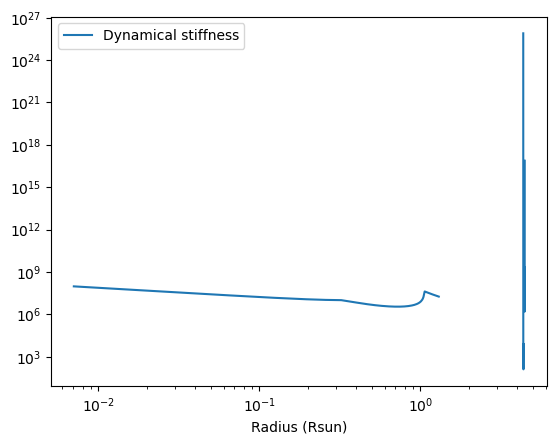

In [98]:
omega_con = 2*np.pi*profMS.conv_vel/(2*profMS.mlt_mixing_length)
avg_brunt = np.average(profMS.brunt_N2[profMS.brunt_N2>1e-9])
print(avg_brunt,profMS.brunt_N2[index_of_radius(2,profMS)])
plt.plot(10**profMS.logR,avg_brunt/omega_con**2,label='Dynamical stiffness')
# plt.plot(10**profMS.logR,profMS.gradr,label='gradr')

plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

In [102]:
Pterm_rad = Pterm(profMS.mass[index_of_radius(1.2,profMS)],10**profMS.logT[index_of_radius(1.2,profMS)],
                  profMS.rho[index_of_radius(1.2,profMS)],profMS.opacity[index_of_radius(1.2,profMS)],
                  profMS.gradr[index_of_radius(1.2,profMS)],profMS.grada[index_of_radius(1.2,profMS)])
Pterm_conv = Pterm(profMS.mass[index_of_radius(0.2,profMS)],10**profMS.logT[index_of_radius(0.2,profMS)],
                   profMS.rho[index_of_radius(0.2,profMS)],profMS.opacity[index_of_radius(0.2,profMS)],
                   profMS.gradr[index_of_radius(0.2,profMS)],profMS.grada[index_of_radius(0.2,profMS)])

In [105]:
print("Penetration parameter", f'{-Pterm_conv/Pterm_rad:1.2E}')
print("Stiffness parameter", f'{profMS.brunt_N2[index_of_radius(1.2,profMS)]/omega_con[index_of_radius(0.2,profMS)]**2:1.2E}')

Penetration parameter 1.13E+00
Stiffness parameter 1.85E+06


## Late burning

In [6]:
profLate = log.profile_data(profile_number=26)

Text(0.5, 0, 'Mass (Msun)')

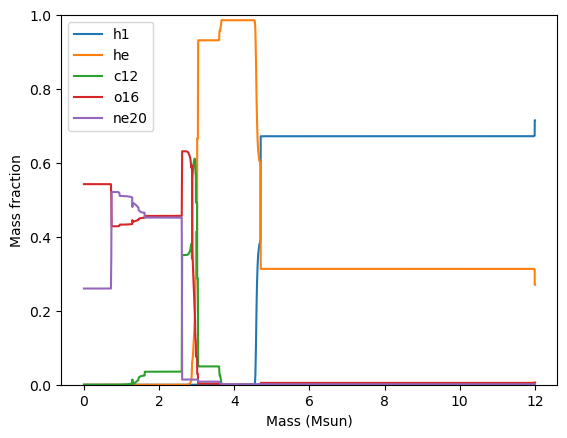

In [14]:
plt.plot(profLate.mass,profLate.h1,label='h1')
plt.plot(profLate.mass,profLate.he4,label='he')
plt.plot(profLate.mass,profLate.c12,label='c12')
plt.plot(profLate.mass,profLate.o16,label='o16')
plt.plot(profLate.mass,profLate.ne20,label='ne20')
plt.ylim(0,1)
plt.legend()
plt.ylabel('Mass fraction')
plt.xlabel('Mass (Msun)')

Text(0.5, 0, 'Radius (Rsun)')

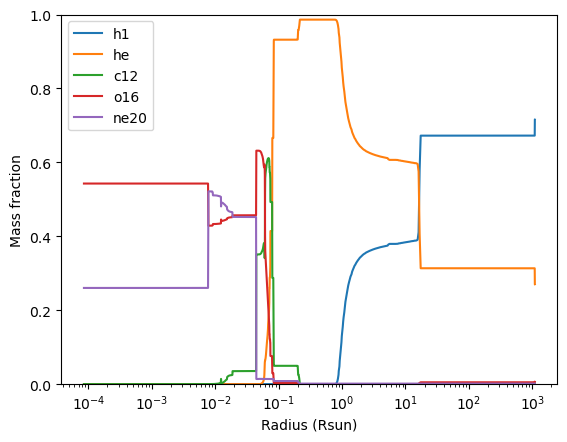

In [15]:
plt.plot(10**profLate.logR,profLate.h1,label='h1')
plt.plot(10**profLate.logR,profLate.he4,label='he')
plt.plot(10**profLate.logR,profLate.c12,label='c12')
plt.plot(10**profLate.logR,profLate.o16,label='o16')
plt.plot(10**profLate.logR,profLate.ne20,label='ne20')
plt.ylim(0,1)
plt.legend()
plt.xscale('log')
plt.ylabel('Mass fraction')
plt.xlabel('Radius (Rsun)')

Text(0.5, 0, 'Radius (Rsun)')

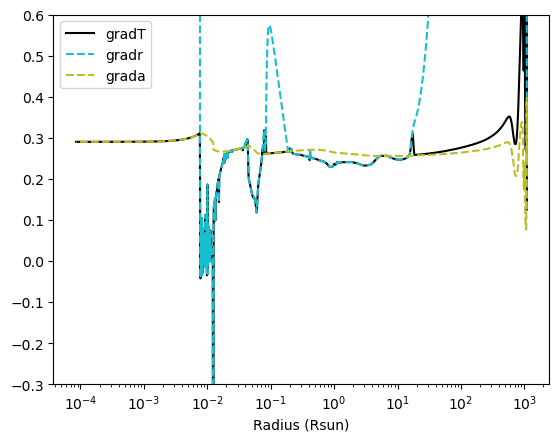

In [7]:


plt.plot(10**profLate.logR,profLate.gradT,label='gradT',c='black')
plt.plot(10**profLate.logR,profLate.gradr,label='gradr',ls='--',c='tab:cyan')
plt.plot(10**profLate.logR,profLate.grada,label='grada',ls="--",c='tab:olive')

# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')

# plt.yscale('log')
# plt.ylim(0,1)
plt.ylim(-0.3,0.6)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

Text(0.5, 0, 'Radius (Rsun)')

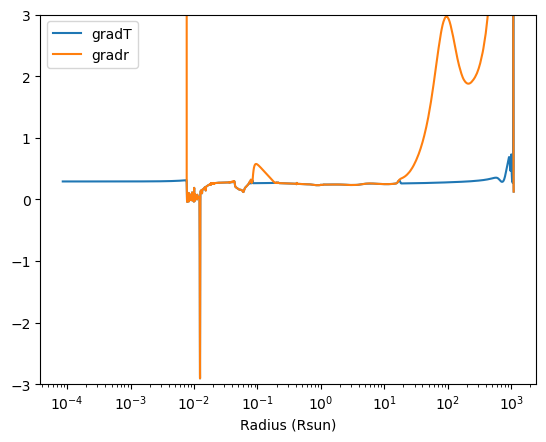

In [17]:
plt.plot(10**profLate.logR,profLate.gradT,label='gradT')
plt.plot(10**profLate.logR,profLate.gradr,label='gradr')
# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')

# plt.yscale('log')
# plt.ylim(0,1)
plt.ylim(-3,3)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

Text(0.5, 0, 'Radius (Rsun)')

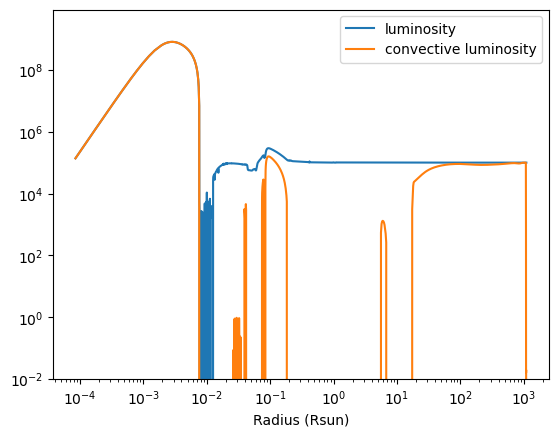

In [42]:
plt.plot(10**profLate.logR,10**profLate.logL,label='luminosity')
plt.plot(10**profLate.logR,profLate.conv_L_div_L*10**profLate.logL,label='convective luminosity')
plt.yscale('log')
# plt.ylim(0,1)
plt.ylim(1e-2,)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

Text(0.5, 0, 'Radius (Rsun)')

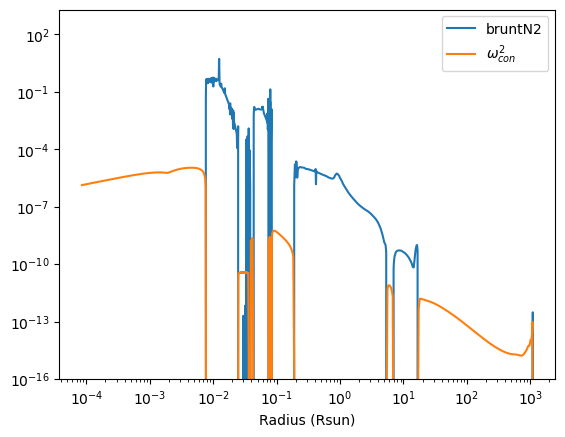

In [34]:
plt.plot(10**profLate.logR,profLate.brunt_N2,label='bruntN2')
omega_con = 2*np.pi*profLate.conv_vel/(2*profLate.mlt_mixing_length)
# plt.plot(10**profLate.logR,profLate.gradr,label='gradr')
plt.plot(10**profLate.logR,omega_con**2,label=r'$\omega_{con}^2$')
plt.yscale('log')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
plt.ylim(1e-16,)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')

In [11]:
index_of_radius(0.07,profLate)

np.int64(618)

Text(0.5, 0, 'Radius (Rsun)')

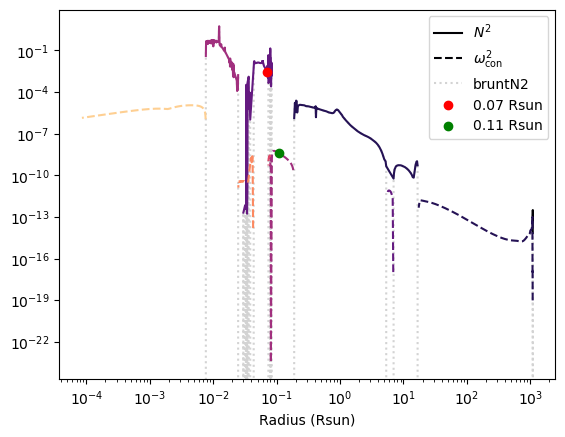

In [90]:

index_groups=consecutive(np.where(profLate.brunt_N2>0)[0],stepsize=20)
mask = np.full(len(profLate.brunt_N2),True,dtype=bool)
for group in index_groups:
    mask[group] = False
omcon_index_groups=consecutive(np.where(mask==True)[0],stepsize=20)

colors = plt.cm.magma(np.linspace(0,0.9,np.max([len(index_groups),len(omcon_index_groups)])))
for i,group in enumerate(index_groups):
    if i ==0:
        label1 = r'$N^2$'
    else:
        label1=None
    plt.plot(10**profLate.logR[group],profLate.brunt_N2[group],label=label1,c=colors[i])#,label=group[0])
omega_con = 2*np.pi*profLate.conv_vel/(2*profLate.mlt_mixing_length)
for i,group2 in enumerate(omcon_index_groups):
    if i ==0:
        label2 = r'$\omega_{\rm con}^2$'
    else:
        label2=None
    plt.plot(10**profLate.logR[group2],omega_con[group2]**2,label=label2,ls='--',c=colors[i])#,label=group2[0],ls='--')
plt.yscale('log')
plt.plot(10**profLate.logR,profLate.brunt_N2,label='bruntN2',zorder=0,c='lightgrey',ls=':')
# plt.ylim(0,1)
# plt.ylim(-1e-2,1e-2)
plt.scatter(10**profLate.logR[index_of_radius(0.07,profLate)],profLate.brunt_N2[index_of_radius(0.07,profLate)],c='red',label='0.07 Rsun',zorder=3)
plt.scatter(10**profLate.logR[index_of_radius(0.11,profLate)],omega_con[index_of_radius(0.11,profLate)]**2,c='green',label='0.11 Rsun',zorder=3)
plt.xscale('log')
plt.legend()
plt.xlabel('Radius (Rsun)')
# plt.ylabel('bruntN2')

In [9]:
def Pterm(Menc,T,rho,kappa,grad_rad,grad_ad):
    return (Menc*T**4/(rho*kappa))*(grad_rad-grad_ad)

In [15]:
profLate.opacity

array([0.00049687, 0.00049687, 0.00049687, ..., 0.03389833, 0.03389708,
       0.03389603])

In [22]:
Pterm_rad = Pterm(profLate.mass[index_of_radius(0.07,profLate)],10**profLate.logT[index_of_radius(0.07,profLate)],
                  profLate.rho[index_of_radius(0.07,profLate)],profLate.opacity[index_of_radius(0.07,profLate)],
                  profLate.gradr[index_of_radius(0.07,profLate)],profLate.grada[index_of_radius(0.07,profLate)])
Pterm_conv = Pterm(profLate.mass[index_of_radius(0.11,profLate)],10**profLate.logT[index_of_radius(0.11,profLate)],
                   profLate.rho[index_of_radius(0.11,profLate)],profLate.opacity[index_of_radius(0.11,profLate)],
                   profLate.gradr[index_of_radius(0.11,profLate)],profLate.grada[index_of_radius(0.11,profLate)])

In [69]:
print("Penetration parameter", f'{-Pterm_conv/Pterm_rad:1.2E}')
print("Stiffness parameter", f'{profLate.brunt_N2[index_of_radius(0.07,profLate)]/omega_con[index_of_radius(0.11,profLate)]**2:1.2E}')

Penetration parameter 7.00E+00
Stiffness parameter 7.78E+05


# 0.7 Msun

In [7]:
# logpt7M=mr.MesaLogDir('./0.7M_pre_ms_to_ZAMS/LOGS_start/')
# h = logpt7M.history_data
hsolar = mr.MesaData('/carnegie/nobackup/users/swu/mesa_r24.03.1_workdir/0.7M_pre_ms_to_ZAMS/z_solar_output/LOGS_start/history.data')
# hnew = mr.MesaData('./0.7M_pre_ms_to_ZAMS/LOGS_start/history.data')
# h = mr.MesaData('./0.7M_pre_ms_to_ZAMS/z_less_solar_output/LOGS_start/history.data')
h = mr.MesaData('/carnegie/nobackup/users/swu/mesa_r24.03.1_workdir/0.7M_pre_ms_to_ZAMS/z_less_solar_rightProt_output/LOGS_start/history.data')

In [4]:
10**0.08

1.202264434617413

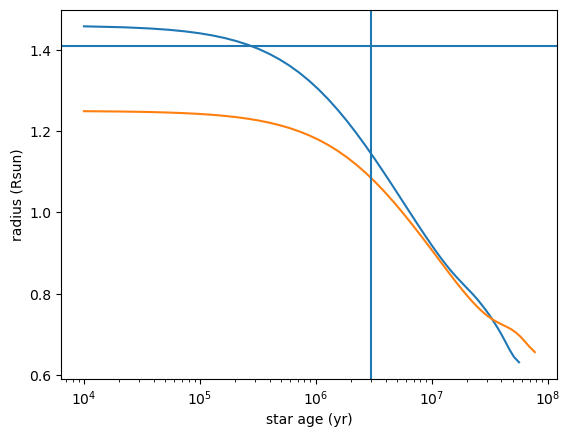

In [10]:
# plt.plot(hnew.data('star_age'),10**hnew.data('log_R'))
plt.plot(h.data('star_age'),10**h.data('log_R'))

plt.plot(hsolar.data('star_age'),10**hsolar.data('log_R'))
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('star age (yr)')
plt.ylabel('radius (Rsun)')
# plt.axvline(2e5)
plt.axvline(3e6)
plt.axhline(1.41)
            

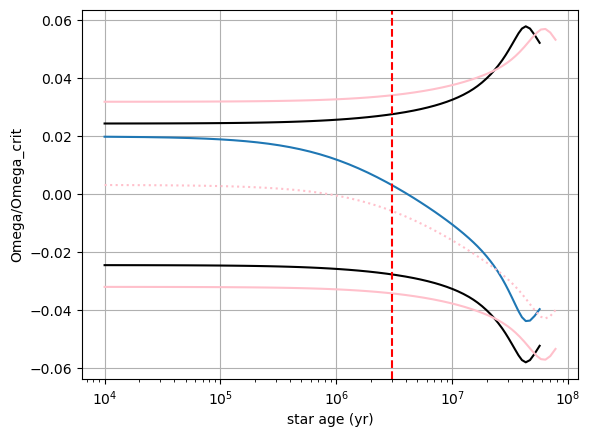

In [11]:
plt.plot(h.data('star_age'),2*h.data('surf_avg_omega_div_omega_crit'),c='black')
plt.plot(h.data('star_age'),-2*h.data('surf_avg_omega_div_omega_crit'),c='black')
plt.plot(h.data('star_age'),2*(2*np.pi/(11*secinday)-h.data('surf_avg_omega'))/h.data('surf_avg_omega_crit'))

plt.plot(hsolar.data('star_age'),2*hsolar.data('surf_avg_omega_div_omega_crit'),c='pink')
plt.plot(hsolar.data('star_age'),-2*hsolar.data('surf_avg_omega_div_omega_crit'),c='pink')
plt.plot(hsolar.data('star_age'),2*(2*np.pi/(11*secinday)-hsolar.data('surf_avg_omega'))/hsolar.data('surf_avg_omega_crit'),ls=':',c='pink')
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('star age (yr)')
plt.ylabel('Omega/Omega_crit')
# plt.axvline(2e5)
# plt.axhspan(-2*h.data('surf_avg_omega_div_omega_crit'),2*h.data('surf_avg_omega_div_omega_crit'))
plt.axvline(3e6,c='red',ls='--')
plt.grid(True)

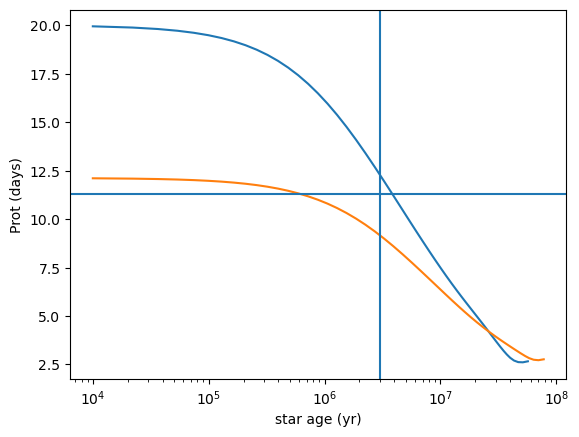

In [12]:
# plt.plot(hnew.data('star_age'),2*np.pi/hnew.data('surf_avg_omega')/secinday)
plt.plot(h.data('star_age'),2*np.pi/h.data('surf_avg_omega')/secinday)
plt.plot(hsolar.data('star_age'),2*np.pi/hsolar.data('surf_avg_omega')/secinday)
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('star age (yr)')
plt.ylabel('Prot (days)')
# plt.axvline(2e5)
plt.axhline(11.3)
plt.axvline(3e6)

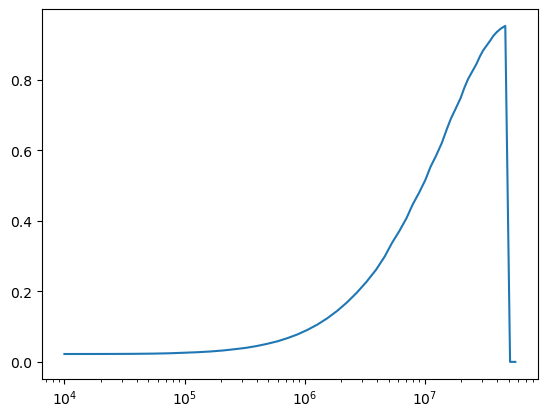

In [13]:
plt.plot(h.data('star_age'),h.data('conv_mx1_bot'))
plt.xscale('log')

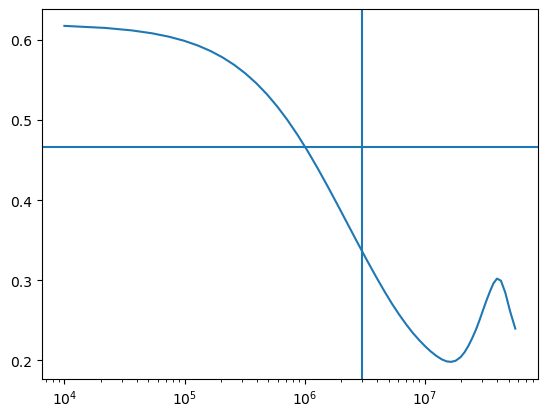

In [16]:
plt.plot(h.data('star_age'),10**h.data('log_L'))
plt.xscale('log')

plt.axhline(0.466)
plt.axvline(3e6)

In [14]:
h.bulk_names

('model_number',
 'num_zones',
 'star_age',
 'log_dt',
 'star_mass',
 'log_xmstar',
 'log_abs_mdot',
 'mass_conv_core',
 'conv_mx1_top',
 'conv_mx1_bot',
 'conv_mx2_top',
 'conv_mx2_bot',
 'mx1_top',
 'mx1_bot',
 'mx2_top',
 'mx2_bot',
 'log_LH',
 'log_LHe',
 'log_LZ',
 'log_Lnuc',
 'pp',
 'cno',
 'tri_alpha',
 'epsnuc_M_1',
 'epsnuc_M_2',
 'epsnuc_M_3',
 'epsnuc_M_4',
 'epsnuc_M_5',
 'epsnuc_M_6',
 'epsnuc_M_7',
 'epsnuc_M_8',
 'he_core_mass',
 'co_core_mass',
 'one_core_mass',
 'fe_core_mass',
 'neutron_rich_core_mass',
 'kh_timescale',
 'log_Teff',
 'log_L',
 'log_R',
 'log_g',
 'v_div_csound_surf',
 'surf_avg_j_rot',
 'surf_avg_omega',
 'surf_avg_omega_crit',
 'surf_avg_omega_div_omega_crit',
 'surf_avg_v_rot',
 'surf_avg_v_crit',
 'surf_avg_v_div_v_crit',
 'surf_avg_Lrad_div_Ledd',
 'log_rotational_mdot_boost',
 'log_center_T',
 'log_center_Rho',
 'log_center_P',
 'log_cntr_P',
 'log_cntr_Rho',
 'log_cntr_T',
 'center_mu',
 'center_ye',
 'center_abar',
 'center_entropy',
 'center_

In [32]:
print(f'{(G*(0.7*Msun)**2/(1.48*Rsun*0.466*Lsun))/secinyear:1.2E} yr')

2.23E+07 yr
